In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import shapely
from tabula import read_pdf
import re
import cap_functs

from sklearn.neighbors import KDTree

%matplotlib inline

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

This notebook is meant to be a venue for looking at the housing datasets for my General Assembly capstone project.

In this project I hope to analyze and target the housing (rentals and sales) prices for San Francisco. Instead of simply using housing prices, whether asking/sale prices or posted rental rates, I will try to incorporate the wealth of other information from neighborhoods to create models that are better at predicting rates. In other words, what is the fair market price for a rental or property. This will try to take into account the specific desires of the buyer/renter specific to regions; i.e., is there a higher preference for living near good food, parks, bars, public transit stops, et cetera?

Below we look through some of the publicly available datasets to see what features we can use in this project. In most cases it is advantageous to have data points connected to geography - latitude/longitude coordinates for each sample in each dataset.

## Airbnb data

These data were downloaded from a third party website that supplies Airbnb sata from cities around the world. An elaborate list of disclaimers is available here (http://insideairbnb.com/about.html#disclaimers). It seems like they took a reasonable approach at cleaning the data, but this should be referenced to be aware of biases.

In [12]:
bnb_cal = pd.read_csv('../ga_project_data/airbnb_data/calendar.csv')
bnb_listings_sum = pd.read_csv('../ga_project_data/airbnb_data/listings_sum.csv')
bnb_listings = pd.read_csv('../ga_project_data/airbnb_data/listings.csv')
bnb_reviews_sum = pd.read_csv('../ga_project_data/airbnb_data/reviews_sum.csv')
bnb_reviews = pd.read_csv('../ga_project_data/airbnb_data/reviews.csv')

In [13]:
print bnb_cal.shape
bnb_cal.head()

(3145935, 4)


listing_id        date available price
0    11187767  2017-03-12         f   NaN
1    11187767  2017-03-11         f   NaN
2    11187767  2017-03-10         f   NaN
3    11187767  2017-03-09         f   NaN
4    11187767  2017-03-08         f   NaN

There are two types of availability, 't' and 'f', not sure what they stand for, but only 't's have prices, making beleive that 't' means true and 'f' means false - probably a safe bet that that is the case. 't' or true must mean that the apartment is unavailable, perhaps it doesn't matter given that the price probably doesn't change much over the course of a month. If there are pricing changes for listings then we can track them month by month or year by year.

In [14]:
print bnb_listings.shape
bnb_listings.head(3)

(8619, 95)


id                            listing_url       scrape_id  \
0  11187767  https://www.airbnb.com/rooms/11187767  20160702162156   
1   6938818   https://www.airbnb.com/rooms/6938818  20160702162156   
2   9395222   https://www.airbnb.com/rooms/9395222  20160702162156   

  last_scraped                                name  \
0   2016-07-02  Huge Seacliff Penthouse With Views   
1   2016-07-02                 Best Secret in Town   
2   2016-07-02       Ocean Beach, Lands End Escape   

                                             summary  \
0  Amazing views from this immense 3 bedroom/ 2 b...   
1  My two story house is located in the quite sid...   
2  Come relax in our 1 bedroom 1 bath house minut...   

                                               space  \
0  Spacious patio deck, library with over 300 mov...   
1  The room is spacious and it is on the top leve...   
2  Huge backyard with a FirePit and lounge chairs...   

                                         description experiences_offered  \
0  Amazing views from this immense 3 bedroom/ 2 b...                none   
1  My two story house is located in the quite sid...                none   
2  Come relax in our 1 bedroom 1 bath house minut...                none   

                               neighborhood_overview        ...          \
0  The neighborhood includes Legion of Honor, Sut...        ...           
1  It is in the city and close to everything. Par...        ...           
2                                                NaN        ...           

  review_scores_value requires_license  \
0                 8.0                t   
1                 9.0                t   
2                 9.0                t   

                                             license jurisdiction_names  \
0                                                NaN      SAN FRANCISCO   
1  S. F. Short-Term Residential Rental Registrati...      SAN FRANCISCO   
2                                                NaN      SAN FRANCISCO   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                t              strict                             f   
1                f              strict                             f   
2                t              strict                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              2   
2                                f                              1   

   reviews_per_month  
0               0.88  
1               1.85  
2               5.87  

[3 rows x 95 columns]

There are a lot text columns that could be used later for NLP analysis. First the data need to be cleaned so that the useful numeric features can be used in the initial model to predict the prices.

First convert dollar value columns to floats. This is done to the calendar table first, which will not be that useful given that the price information is already given in the main listing table. The calendar table does show that prices for some listings change during certain periods of time, like weekends or holidays. A mean of these prices are taken and then added to the main listing table as a column named 'price_mod'.

In [18]:
bnb_cal.price.value_counts(dropna=False).head(5)

NaN        1909112
$150.00      45065
$200.00      35702
$250.00      33873
$100.00      28943
Name: price, dtype: int64

In [19]:
# function to convert "numeric" strings to floats
def conv_to_float(s):
    if s:
        return float(s)
    else:
        return s

# function to convert string dollar amounts to floats
def conv_dollars(df, list_of_cols):
    for col in list_of_cols:
        df[col] = df[col].replace(to_replace=r'[^0-9.]+', value='', regex=True)
        df[col] = df[col].apply(conv_to_float)
    return df

In [23]:
bnb_cal['price'] = bnb_cal.price.replace(to_replace=r'[^0-9.]+', value='', regex=True, )
bnb_cal['price'] = bnb_cal.price.apply(conv_to_float, convert_dtype=True)
bnb_cal.price.value_counts(dropna=False).head(5)

NaN       1909112
 150.0      45065
 200.0      35702
 250.0      33873
 100.0      28943
Name: price, dtype: int64

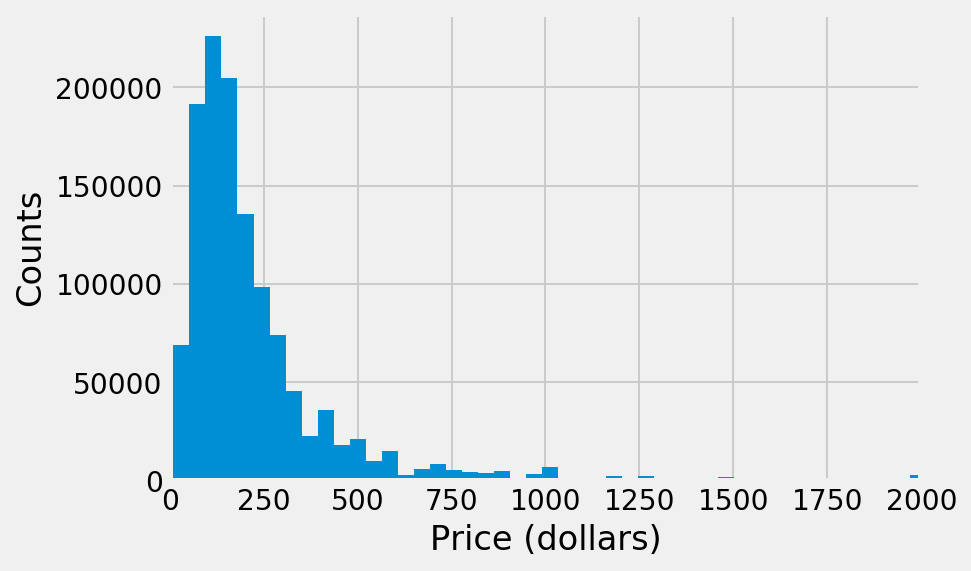

In [26]:
bnb_cal.price.hist(bins=300,)
plt.xlim((0, 2000))
plt.xlabel('Price (dollars)')
plt.ylabel('Counts');

The Airbnb calendar dataset gives a list of prices for the listings over the past year. If the unit is available for rent, a price is listed. Some listings have the same price over the entire year and other listings have different pricing schemes for certain periods of time. Below, I show a listing that is $90 more expensive on weekends. This may also be the case for some listings over holiday periods or popular vacation times (e.g. spring break or Memorial Day).

In [27]:
print bnb_cal[bnb_cal.listing_id == 13590516].shape
bnb_cal[bnb_cal.listing_id == 13590516].head(4)

(365, 4)


listing_id        date available  price
17155    13590516  2017-07-01         t  525.0
17156    13590516  2017-06-30         t  525.0
17157    13590516  2017-06-29         t  434.0
17158    13590516  2017-06-28         t  434.0

In [29]:
print bnb_listings_sum.shape
bnb_listings_sum.head(3)

(8619, 16)


id                                name   host_id host_name  \
0  11187767  Huge Seacliff Penthouse With Views  58242037  Jonathan   
1   6938818                 Best Secret in Town  36381578    Harris   
2   9395222       Ocean Beach, Lands End Escape  25963295     Tyler   

   neighbourhood_group neighbourhood   latitude   longitude        room_type  \
0                  NaN      Seacliff  37.779685 -122.510472  Entire home/apt   
1                  NaN      Seacliff  37.780659 -122.505635     Private room   
2                  NaN      Seacliff  37.781433 -122.505179  Entire home/apt   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    400               2                  3  2016-06-25               0.88   
1     99               3                 23  2016-06-16               1.85   
2    155               1                 45  2016-06-19               5.87   

   calculated_host_listings_count  availability_365  
0                               1               152  
1                               2               187  
2                               1               167

The reviews table gives some reviews for many of the units listed. Some of listings don't have reviews, either because they are infrequently rented or are too new to have any reviews yet.

In [30]:
bnb_reviews.listing_id.unique().shape

(6396,)

In [31]:
print bnb_reviews.shape
bnb_reviews.head()

(169739, 6)


listing_id        id        date  reviewer_id      reviewer_name  \
0     8308113  47419975  2015-09-18      6288054              Colin   
1     3320213  14805088  2014-06-26     17101713               Faye   
2     3320213  17192435  2014-08-08       182792  Jocelyne & Pontus   
3     3320213  17597907  2014-08-14     19649465          Francesco   
4     3320213  18293826  2014-08-24      1104165             Daniel   

                                            comments  
0  Host was excellent and was contactable / respo...  
1  The place was clean and spacious and the guy t...  
2  This place wasn't as pleasant as we hoped. Had...  
3  Si tratta di una piccola pensione/albergo.\nSt...  
4  Nice room, cool neighbourhood. Note that this ...

The reviews summary table will probably not be used, it contains a date and listing_id for each review.

In [33]:
print bnb_reviews_sum.shape
bnb_reviews_sum.head()

(169739, 2)


listing_id        date
0     8308113  2015-09-18
1     3320213  2014-06-26
2     3320213  2014-08-08
3     3320213  2014-08-14
4     3320213  2014-08-24

There are far more recent reviews from 2015 and 2016 as airbnb has gotten more popular and more people are listing and renting.

## SF city data

### 311 records

There are many 311 records or requests in the city records. These could be anything from complaints for sidewalk or light repairs to requests to remove illegal sign postings or paint curbs for parking restrictions.

In [34]:
rec_311 = pd.read_csv('../ga_project_data/sf_city_data/311_case_records/311_records.csv')

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
print rec_311.shape
rec_311.head(3)

(1821839, 16)


CaseID                  Opened                  Closed  \
0  322571  11/30/2008 11:53:00 PM  12/01/2008 03:19:00 PM   
1  322568  11/30/2008 11:13:00 PM  07/21/2009 04:24:00 PM   
2  322567  11/30/2008 11:07:00 PM  12/27/2008 06:07:00 AM   

                  Updated  Status Status Notes        Responsible Agency  \
0  12/01/2008 03:19:00 PM  Closed          NaN  PUC - Electric/Power - G   
1  07/21/2009 04:24:00 PM  Closed          NaN             DPW Ops Queue   
2  12/27/2008 06:07:00 AM  Closed          NaN             DPW Ops Queue   

           Category                                  Request Type  \
0  General Requests          puc - electric - request_for_service   
1  Illegal Postings  Illegal Postings - Posting_Too_Large_in_Size   
2  Illegal Postings         Illegal Postings - Affixed_Improperly   

                         Request Details  \
0   puc - electric - request_for_service   
1  Posting_Too_Large_in_Size on Sidewalk   
2         Affixed_Improperly on Sidewalk   

                                      Address  Supervisor District  \
0         Intersection of 21ST ST and CAPP ST                    9   
1    Intersection of BUSH ST and VAN NESS AVE                    3   
2  Intersection of EUCLID AVE and MASONIC AVE                    2   

       Neighborhood                                  Point    Source Media URL  
0           Mission  (37.7571008516766, -122.417811874214)  Voice In       NaN  
1          Nob Hill  (37.7884895281133, -122.421948485141)  Voice In       NaN  
2  Western Addition  (37.7850837365507, -122.447620029034)  Voice In       NaN

These records date back to 2008. In order to make better predictions only recent data are included (this range is restricted in other jupyter notebooks). This also helps restrict the sheer amount of data points.

In [36]:
rec_311.Category.value_counts()

Street and Sidewalk Cleaning    636346
Graffiti Public Property        173169
General Requests                133050
Graffiti Private Property       132591
Abandoned Vehicle               129793
Damaged Property                 71597
SFHA Requests                    64117
Sewer Issues                     58085
Streetlights                     48497
Tree Maintenance                 45370
MUNI Feedback                    43864
Street Defects                   39155
Litter Receptacles               37458
Illegal Postings                 35902
Sign Repair                      32613
Rec and Park Requests            30541
Sidewalk or Curb                 27904
Temporary Sign Request           24892
311 External Request             17156
Blocked Street or SideWalk       14565
Residential Building Request      7950
Color Curb                        5372
Catch Basin Maintenance           4852
Noise Report                      2955
Construction Zone Permits         2044
Interdepartmental Request

### Parks

'Park_info.csv' contains geolocated information about the many parks in San Francisco. 

'park_scores.csv' contains scores for the various parks. Need to figure out exactly how these scores are given. It will be difficult to link the scores with the locations of the actual parks. This would be ideal, since there are parks that are generally better to be located next to. However, we are just going to use a shapefile and count the number of boundary points that are within a certain radius from a given location.

In [45]:
park_info = pd.read_csv('../ga_project_data/sf_city_data/parks/park_info.csv', header=0)
park_scores = pd.read_csv('../ga_project_data/sf_city_data/parks/park_scores.csv')

In [47]:
print park_info.shape
park_info.head(4)

(230, 12)


ParkName   ParkType  ParkServiceArea     PSAManager  \
0                    ParkName   ParkType  ParkServiceArea     PSAManager   
1  10TH AVE/CLEMENT MINI PARK  Mini Park            PSA 1   Elder, Steve   
2           15TH AVENUE STEPS  Mini Park            PSA 4  Sheehy, Chuck   
3         24TH/YORK MINI PARK  Mini Park            PSA 6  Field, Adrian   

                      email          Number  Zipcode  Acreage  SupDist  \
0                     email          Number      NaN      NaN      NaN   
1    steven.elder@sfgov.org  (415) 601-6501  94118.0     0.66      1.0   
2  charles.sheehy@sfgov.org  (415) 218-2226  94122.0     0.26      7.0   
3    adrian.field@sfgov.org  (415) 717-2872  94110.0     0.12      9.0   

   ParkID                                         Location 1  Lat  
0     NaN                                                NaN  NaN  
1   156.0  351 9th Ave\nSan Francisco, CA\n(37.78184397, ...  NaN  
2   185.0  15th Ave b w Kirkham\nSan Francisco, CA\n(37.7...  NaN  
3    51.0  24th\nSan Francisco, CA\n(37.75306042, -122.40...  NaN

In [48]:
print park_scores.shape
park_scores.head()

(5495, 5)


ParkID   PSA                       Park      FQ  Score
0      86  PSA4           Carl Larsen Park  FY05Q3  0.795
1      13  PSA4  Junipero Serra Playground  FY05Q3  0.957
2       9  PSA4     Rolph Nicol Playground  FY05Q3  0.864
3     117  PSA2               Alamo Square  FY05Q4  0.857
4      60  PSA6   Jose Coronado Playground  FY05Q4  0.859

The park info and scores tables contain a lot of useful information. But the only information that we include in this initial project are the shapefile boundaries for parks, which we obtain from another source. This is discussion further in other notebooks.

### SF crime data

San Francisco provides data on crimes (or SFPD incidents) back to 2003. This time frame may need to be adjusted so that possible estimators are current and so that there isn't too much data.

In [49]:
crimes_sf = pd.read_csv('../ga_project_data/sf_city_data/sf_crime/sfpd_incidents_from2003.csv')

In [50]:
print crimes_sf.shape
crimes_sf.head(3)

(1945294, 13)


IncidntNum        Category        Descript DayOfWeek        Date   Time  \
0   110914565        WARRANTS  WARRANT ARREST    Friday  05/29/2015  16:42   
1    11351210  MISSING PERSON    FOUND PERSON   Tuesday  06/14/2016  08:55   
2   120789988  MISSING PERSON    FOUND PERSON    Monday  05/16/2016  00:41   

  PdDistrict      Resolution                     Address           X  \
0   SOUTHERN  ARREST, BOOKED          BRYANT ST / 8TH ST -122.406971   
1    BAYVIEW            NONE        1200 Block of 3RD ST -122.389518   
2  INGLESIDE            NONE  WOOLSEY ST / UNIVERSITY ST -122.412470   

           Y                               Location            PdId  
0  37.772527  (37.7725273607571, -122.406970988225)  11091456563010  
1  37.772468  (37.7724682400061, -122.389517648036)   1135121075000  
2  37.722659  (37.7226585129212, -122.412469643631)  12078998875000

In [51]:
crimes_sf.Category.value_counts()

LARCENY/THEFT                  400224
OTHER OFFENSES                 276609
NON-CRIMINAL                   207987
ASSAULT                        170313
VEHICLE THEFT                  116480
DRUG/NARCOTIC                  113099
VANDALISM                       99417
WARRANTS                        92224
BURGLARY                        81024
SUSPICIOUS OCC                  69855
MISSING PERSON                  57243
ROBBERY                         49960
FRAUD                           36970
SECONDARY CODES                 22271
FORGERY/COUNTERFEITING          22055
WEAPON LAWS                     19155
TRESPASS                        16483
PROSTITUTION                    15839
STOLEN PROPERTY                 10437
SEX OFFENSES, FORCIBLE           9912
DISORDERLY CONDUCT               9211
DRUNKENNESS                      9207
RECOVERED VEHICLE                7690
DRIVING UNDER THE INFLUENCE      5093
KIDNAPPING                       4946
RUNAWAY                          4047
LIQUOR LAWS 

A number of these categories will be chosen for inclusion in the initial model. Each category could have a completely different predictive potential.

### Other possible SF city datasets

Some other datasets may be useful for some of this project. The zillow property sales table includes useful information but is not used in this project. There are also two different Assessor datasets. The tax roll table is used as one of the primary datasets for this study, along with the Airbnb dataset.

#### Zillow property sales

Zillow has its own API that could provide a wealth of information - I need to dig deeper into that later. For now, here is the Zillow dataset provided that describes median sale prices ***per square foot*** for homes across the country.

In [52]:
zillow_median_sale = pd.read_csv('../ga_project_data/sf_city_data/zillow_property_sales/zillow_mediansale_persqft_neighborhood.csv')

In [53]:
print zillow_median_sale.shape
zillow_median_sale.head()

(4238, 250)


RegionID        RegionName         City State  \
0    274772  Northeast Dallas       Dallas    TX   
1    192689          Paradise    Las Vegas    NV   
2    112345          Maryvale      Phoenix    AZ   
3    270958   Upper West Side     New York    NY   
4     27080      Sherman Oaks  Los Angeles    CA   

                            Metro   CountyName  SizeRank   1996-04   1996-05  \
0               Dallas-Fort Worth       Dallas         1       NaN       NaN   
1                       Las Vegas        Clark         2   71.7410   71.7994   
2                         Phoenix     Maricopa         3   46.6023   47.1911   
3                        New York     New York         4  267.2269  284.3680   
4  Los Angeles-Long Beach-Anaheim  Los Angeles         5  105.4025  102.1831   

    1996-06    ...        2015-09    2015-10    2015-11    2015-12    2016-01  \
0       NaN    ...       157.5133   151.1346   148.4390   154.5512   151.9219   
1   70.7296    ...       119.4710   119.0146   116.6964   114.6923   113.0189   
2   47.1452    ...        90.0998    91.9159    93.4707    95.0144    94.9214   
3  282.8276    ...      1412.9753  1399.5488  1392.7152  1492.7994  1536.2801   
4   99.7840    ...       421.2244   425.3723   423.0285   415.3199   411.3433   

     2016-02    2016-03    2016-04    2016-05    2016-06  
0   158.5226   165.6903   170.1752   176.2920   180.1894  
1   113.8884   114.8041   116.3150   118.9096        NaN  
2    95.2213    96.8052    97.2812    98.3929   100.1619  
3  1462.3706  1458.9674  1426.4533  1485.8095  1480.3050  
4   451.6802   472.8199   492.2803   494.7221   509.6003  

[5 rows x 250 columns]

In [56]:
print zillow_median_sale[zillow_median_sale.CountyName == 'San Francisco'].shape
zillow_median_sale[zillow_median_sale.CountyName == 'San Francisco'].head(3)

(55, 250)


RegionID        RegionName           City State          Metro  \
113    274552           Mission  San Francisco    CA  San Francisco   
340    268020    Bernal Heights  San Francisco    CA  San Francisco   
403    117654  Central Richmond  San Francisco    CA  San Francisco   

        CountyName  SizeRank   1996-04   1996-05   1996-06    ...      \
113  San Francisco       114       NaN  165.0000  174.2246    ...       
340  San Francisco       341  199.9639  197.9637  190.1546    ...       
403  San Francisco       404       NaN       NaN       NaN    ...       

      2015-09    2015-10   2015-11    2015-12   2016-01  2016-02   2016-03  \
113  992.9989  1007.8958  979.4455  1005.1700  1009.133      NaN  949.5807   
340  950.6946  1046.6708       NaN   953.7609       NaN      NaN       NaN   
403       NaN        NaN       NaN        NaN       NaN      NaN       NaN   

       2016-04    2016-05    2016-06  
113   972.4858  1037.1023        NaN  
340  1000.0000  1097.4790  1069.1111  
403        NaN        NaN        NaN  

[3 rows x 250 columns]

#### Assesor office data

Assessor data from SF City that provides information on property and sales over a given time interval. This first dataset might not be used given the other information available, including the following tax roll dataset, also from the Assessor's office (but downloaded from https://data.sfgov.org/).

In [57]:
# I'm going to load just the most recent data for now
sf_assessor = pd.read_csv('../ga_project_data/sf_city_data/assessor_office/assessor_data_2014_2015.csv')

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
print sf_assessor.shape
sf_assessor.head()

(206816, 41)


PROPLOC RP1NBRCDE RP1PRCLID  BASELOT  \
0  0000 0000                       0000       08H  0001 001        0   
1  0000 0000                       0000       08H  0002 001        0   
2  0000 0000                       0000       08H  0004 002        0   
3  0000 0000                       0000       08H  0005 001        0   
4  0000 0000                       0000       08H  0006 001        0   

  BASELOTSFX  RP1VOLUME RP1CLACDE  YRBLT  BATHS  BEDS    ...      EXEMPTYPE  \
0        NaN          1         G   1900      0     0    ...            NaN   
1        NaN          1         G   1900      0     0    ...            NaN   
2        NaN          1       VCI      0      0     0    ...            NaN   
3        NaN          1         G   1900      0     0    ...            NaN   
4        NaN          1         G   1900      0     0    ...            NaN   

   RP1STACDE  RP1EXMVL2  RP1EXMVL1 ROLLYEAR RECURRSALD  RP1FXTVAL RP1IMPVAL  \
0          N          0          0       14          0          0         0   
1          N          0          0       14          0          0         0   
2          N          0          0       14          0          0         0   
3          N          0          0       14          0          0         0   
4          N          0          0       14          0          0         0   

  RP1LNDVAL  RP1PPTVAL  
0         0          0  
1         0          0  
2         0          0  
3         0          0  
4         0          0  

[5 rows x 41 columns]

Additional data from the Assessor-Recorder's office that includes historic data for the Secured Property Tax Rolls. This is a great resource and will be cleaned and used in parallel with the airbnb model. Should be interesting to see how the results compare for each dataset.

In [142]:
tax_rolls = pd.read_csv('../ga_project_data/sf_city_data/secured_property_tax_rolls.csv')

In [143]:
print tax_rolls.shape
tax_rolls.head()

(1817896, 42)


Closed Roll Fiscal Year                      Property Location  \
0                   2012.0  0000 0188 MINNA               ST0024C   
1                   2014.0   0000 1006 COLE                ST0000   
2                   2007.0   0000 0000VWEBSTER             ST0000   
3                   2014.0   0000 0601 VAN NESS            AV0044   
4                   2008.0   0000 1221 HARRISON            ST0014   

  Neighborhood Code Neighborhood Code Definition Block and Lot Number  \
0               09B                          NaN              3722273   
1               05E    Parnassus/Ashbury Heights              1278032   
2               06C        Lower Pacific Heights              0685050   
3               08F       Van Ness/ Civic Center              0762044   
4               09F              South of Market              3757127   

   Volume Number Property Class Code Property Class Code Definition  \
0             25                   Z                              Z   
1              9                   Z                              Z   
2              5                   V                              V   
3              6                   Z                              Z   
4             25                  LZ                             LZ   

   Year Property Built  Number of Bathrooms  \
0               2005.0                  2.0   
1               1907.0                  3.0   
2               1900.0                  0.0   
3               1982.0                  3.0   
4               2004.0                  0.0   

                   ...                    Closed Roll Misc Exemption Value  \
0                  ...                                                 0.0   
1                  ...                                                 0.0   
2                  ...                                                 0.0   
3                  ...                                                 0.0   
4                  ...                                                 0.0   

   Closed Roll Homeowner Exemption Value  Current Sales Date  \
0                                    0.0          07/31/1990   
1                                    0.0          04/15/2011   
2                                    0.0                 NaN   
3                                 7000.0          01/31/2010   
4                                    0.0          05/28/1940   

   Closed Roll Assessed Fixtures Value  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   Closed Roll Assessed Improvement Value Closed Roll Assessed Land Value  \
0                                760483.0                       1140725.0   
1                                346562.0                        519843.0   
2                                 17572.0                        182948.0   
3                                295002.0                        295002.0   
4                                249383.0                        424483.0   

  Closed Roll Assessed Personal Prop Value  Supervisor District  \
0                                      0.0                  6.0   
1                                      0.0                  5.0   
2                                      0.0                  5.0   
3                                      0.0                  5.0   
4                                      0.0                  6.0   

   Neighborhoods - Analysis Boundaries                               Location  
0       Financial District/South Beach  (37.7862913318072, -122.401375181471)  
1                       Haight Ashbury  (37.7646938184545, -122.449439257453)  
2                            Japantown  (37.7860078381928, -122.430650176965)  
3                     Western Addition  (37.7813857775995, -122.421406328014)  
4                      South of Market    (37.7731031100387, -122.

The focus is on residential housing values, so only properties with residential class codes are included.

In [144]:
resid_class_codes = ['CO', 'COS', 'D', 'DBM', 'LZ', 'LZBM', 'TH', 'THBM', 
                   'Z', 'ZBM', 'A', 'CO', 'DA', 'DD', 'DF', 'F', 'FA', 
                   'F2', 'OA', 'TIA', 'TIF', 'XV']

In [145]:
res_tax_rolls = tax_rolls[tax_rolls['Property Class Code'].isin(resid_class_codes)]
print res_tax_rolls.shape
res_tax_rolls.head()

(1571041, 42)


Closed Roll Fiscal Year                      Property Location  \
0                   2012.0  0000 0188 MINNA               ST0024C   
1                   2014.0   0000 1006 COLE                ST0000   
3                   2014.0   0000 0601 VAN NESS            AV0044   
4                   2008.0   0000 1221 HARRISON            ST0014   
5                   2012.0   0000 0517 11TH                AV0000   

  Neighborhood Code Neighborhood Code Definition Block and Lot Number  \
0               09B                          NaN              3722273   
1               05E    Parnassus/Ashbury Heights              1278032   
3               08F       Van Ness/ Civic Center              0762044   
4               09F              South of Market              3757127   
5               01B               Inner Richmond              1554002   

   Volume Number Property Class Code Property Class Code Definition  \
0             25                   Z                              Z   
1              9                   Z                              Z   
3              6                   Z                              Z   
4             25                  LZ                             LZ   
5             11                   D                              D   

   Year Property Built  Number of Bathrooms  \
0               2005.0                  2.0   
1               1907.0                  3.0   
3               1982.0                  3.0   
4               2004.0                  0.0   
5               1913.0                  0.0   

                   ...                    Closed Roll Misc Exemption Value  \
0                  ...                                                 0.0   
1                  ...                                                 0.0   
3                  ...                                                 0.0   
4                  ...                                                 0.0   
5                  ...                                                 0.0   

   Closed Roll Homeowner Exemption Value  Current Sales Date  \
0                                    0.0          07/31/1990   
1                                    0.0          04/15/2011   
3                                 7000.0          01/31/2010   
4                                    0.0          05/28/1940   
5                                    0.0                 NaN   

   Closed Roll Assessed Fixtures Value  \
0                                  0.0   
1                                  0.0   
3                                  0.0   
4                                  0.0   
5                                  0.0   

   Closed Roll Assessed Improvement Value Closed Roll Assessed Land Value  \
0                                760483.0                       1140725.0   
1                                346562.0                        519843.0   
3                                295002.0                        295002.0   
4                                249383.0                        424483.0   
5                                 42819.0                         35093.0   

  Closed Roll Assessed Personal Prop Value  Supervisor District  \
0                                      0.0                  6.0   
1                                      0.0                  5.0   
3                                      0.0                  5.0   
4                                      0.0                  6.0   
5                                      0.0                  1.0   

   Neighborhoods - Analysis Boundaries                               Location  
0       Financial District/South Beach  (37.7862913318072, -122.401375181471)  
1                       Haight Ashbury  (37.7646938184545, -122.449439257453)  
3                     Western Addition  (37.7813857775995, -122.421406328014)  
4                      South of Market    (37.7731031100387, -122.4086736996)  
5                       Inner Richmond  (37.7784931441868, -122.46

Below I imputed 1 into places that had 0 stories listed. This could be a mistake given that maybe they are properties zoned for residential that may be empty pieces of land (or have some other type of minor structure). Should definitely look into finding a better alternative if there is one. There are 22755 such rows, about 13.5% of the rows.

A lot more could be eliminated in order to make sure that predictions are being made on a similar group of houses. Changes that could be made are: considering whether or not to include only traditional houses or apartments with at least a bedroom and bathroom, eliminating some or the sales that have strange values for certain attributes like far too many floors, stories, rooms, etc.

In [146]:
# restrict years to > 2010
res_rolls_15up = res_tax_rolls[res_tax_rolls['Closed Roll Fiscal Year'] > 2010]
# eliminate all properties with no location coordinates
res_rolls_15up = res_rolls_15up[res_rolls_15up.Location.notnull()]
# convert Location column into two new columns for latitude and longitude
res_rolls_15up['latitude'] = res_rolls_15up.Location.apply(lambda x: float((x.strip('()').split(', ')[0])))
res_rolls_15up['longitude'] = res_rolls_15up.Location.apply(lambda x: float((x.strip('()').split(', '))[1]))
# eliminate residential properties with properties outside of a logical range for SF
res_rolls_15up = res_rolls_15up[res_rolls_15up['Number of Bathrooms'] < 14]
res_rolls_15up = res_rolls_15up[res_rolls_15up['Number of Rooms'] < 40]
res_rolls_15up = res_rolls_15up[res_rolls_15up['Number of Stories'] < 7]
res_rolls_15up['Number of Stories'] = res_rolls_15up['Number of Stories'].map(lambda x: 1 if x == 0 else x)
# eliminate properties with implausible dates for Year Property Built
res_rolls_15up = res_rolls_15up[res_rolls_15up['Year Property Built'] > 1800]
res_rolls_15up = res_rolls_15up[res_rolls_15up['Year Property Built'] < 2017]
# create new age column for properties
res_rolls_15up['age'] = 2017 - res_rolls_15up.loc[:, "Year Property Built"]
# create value column that will be model target, this includes the land and improvement values added
res_rolls_15up['land_and_impro_val'] = res_rolls_15up.loc[:, "Closed Roll Assessed Improvement Value"] +\
                                        res_rolls_15up.loc[:, "Closed Roll Assessed Land Value"]
# eliminate properties with values of 0
res_rolls_15up = res_rolls_15up[res_rolls_15up['land_and_impro_val'] != 0.0]
res_rolls_15up.reset_index(inplace=True, drop=True)
print res_rolls_15up.shape
res_rolls_15up.head(2)

(834471, 46)


Closed Roll Fiscal Year                      Property Location  \
0                   2012.0  0000 0188 MINNA               ST0024C   
1                   2014.0   0000 1006 COLE                ST0000   

  Neighborhood Code Neighborhood Code Definition Block and Lot Number  \
0               09B                          NaN              3722273   
1               05E    Parnassus/Ashbury Heights              1278032   

   Volume Number Property Class Code Property Class Code Definition  \
0             25                   Z                              Z   
1              9                   Z                              Z   

   Year Property Built  Number of Bathrooms         ...          \
0               2005.0                  2.0         ...           
1               1907.0                  3.0         ...           

   Closed Roll Assessed Improvement Value  Closed Roll Assessed Land Value  \
0                                760483.0                        1140725.0   
1                                346562.0                         519843.0   

   Closed Roll Assessed Personal Prop Value  Supervisor District  \
0                                       0.0                  6.0   
1                                       0.0                  5.0   

   Neighborhoods - Analysis Boundaries                               Location  \
0       Financial District/South Beach  (37.7862913318072, -122.401375181471)   
1                       Haight Ashbury  (37.7646938184545, -122.449439257453)   

    latitude   longitude    age  land_and_impro_val  
0  37.786291 -122.401375   12.0           1901208.0  
1  37.764694 -122.449439  110.0            866405.0  

[2 rows x 46 columns]

In [147]:
res_rolls_15up.isnull().sum()

Closed Roll Fiscal Year                            0
Property Location                                  0
Neighborhood Code                                  4
Neighborhood Code Definition                   13163
Block and Lot Number                               0
Volume Number                                      0
Property Class Code                                0
Property Class Code Definition                     0
Year Property Built                                0
Number of Bathrooms                                0
Number of Bedrooms                                 0
Number of Rooms                                    0
Number of Stories                                  0
Number of Units                                    0
Characteristics Change Date                   834471
Zoning Code                                   109885
Construction Type                             101702
Lot Depth                                          0
Lot Frontage                                  

There are quite a few sales in the rolls that have no bedrooms or rooms listed (the both contain values of 0). This will certainly throw the model off - it's unclear what these sales actually are. Because there is still a lot of other data that can be used, we discard these units which number just under 15000 rows.

In [148]:
print res_rolls_15up.shape
res_rolls_15up = res_rolls_15up[(res_rolls_15up['Number of Rooms'] > 0) & (res_rolls_15up['Number of Bedrooms'] > 0)]
print res_rolls_15up.shape

(834471, 46)
(301138, 46)


Finally, we create the final table with numeric values that will serve as the baseline Assessor property dataset.

In [149]:
res_rolls_cols = ['Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms', 
                  'Number of Stories', 'Number of Units', 'Property Area in Square Feet', 
                  'Percent of Ownership', 'land_and_impro_val', 'age', 'latitude', 'longitude']
res_rolls_cut = res_rolls_15up[res_rolls_cols]
print res_rolls_cut.shape
res_rolls_cut.head()

(301138, 11)


Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                   2.0                   2                5   
1                   3.0                   3                6   
2                   3.0                   3                5   
4                   2.0                   2               10   
10                  3.0                   3                6   

    Number of Stories  Number of Units  Property Area in Square Feet  \
0                   1                0                          1670   
1                   1                1                          1450   
2                   2                1                          1037   
4                   3                1                          2920   
10                  1                1                          1705   

    Percent of Ownership  land_and_impro_val    age   latitude   longitude  
0                    1.0           1901208.0   12.0  37.786291 -122.401375  
1                    1.0            866405.0  110.0  37.764694 -122.449439  
2                    1.0            590004.0   35.0  37.781386 -122.421406  
4                    1.0            321306.0  113.0  37.770028 -122.443385  
10                   1.0            717439.0   92.0  37.776400 -122.503483

Above is essentially the pruned and cleaned tax roll of residential units that I will add other geographic features to.

Firstly, going to load the census tracts and data for each one. The US government keeps track of the median family income and percentage of people below the poverty line in each census tract. This will be added to each unit from the tax rolls and also to each airbnb listing (later in this notebook).

In [150]:
sf_tracts = gpd.read_file("../capstone/map_data/census_tracts/geo_export_7bc0cbf4-37f3-4834-8345-85a3e6c2888f.shp")
sf_tracts.head(3)


aland10  awater10 countyfp10 tractce10 mtfcc10 name10        namelsad10  \
0  370459.0       0.0        075    016500   G5020    165  Census Tract 165   
1  309097.0       0.0        075    016400   G5020    164  Census Tract 164   
2  245867.0       0.0        075    016300   G5020    163  Census Tract 163   

     intptlon10 funcstat10   intptlat10 statefp10      geoid10  \
0  -122.4477884          S  +37.7741958        06  06075016500   
1  -122.4369729          S  +37.7750995        06  06075016400   
2  -122.4295509          S  +37.7760456        06  06075016300   

                                            geometry  
0  POLYGON ((-122.446471 37.775802, -122.44478 37...  
1  POLYGON ((-122.44034 37.77658, -122.439844 37....  
2  POLYGON ((-122.429152 37.778007, -122.428909 3...

In [73]:
# Used to export a shapefile for plotting in QGIS and Carto
# sf_tracts_mod[['geometry', 'med_fam_inc_est16', 'percent_below_poverty']].to_file('tracts_inc_pov.shp', driver='ESRI Shapefile')

Below, geopandas and shapely are used to create a new geodataframe that assigns the appropriatly values for income and poverty for each tract that is listed for every row.

In [74]:
# function used to assign census track to new df column, requires sf_tracs to be loaded above
def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in sf_tracts['geometry']]
    if True in bools:
        return sf_tracts.iloc[bools.index(True)]['name10']
    else:
        return np.nan

In [75]:
# creating new data frame that includes two new columns with median income and poverty level given location
res_rolls_cut_geo = gpd.GeoDataFrame(res_rolls_cut, crs={'init': 'epsg:4326'}, geometry=res_rolls_cut.apply(\
                    lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'))

res_rolls_cut_geo['census_tract'] = res_rolls_cut_geo.apply(assign_census_tract, axis='columns')
res_rolls_cut_geo.head(3)

Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                  2.0                   2                5   
1                  3.0                   3                6   
2                  3.0                   3                5   

   Number of Stories  Number of Units  Property Area in Square Feet  \
0                  1                0                          1670   
1                  1                1                          1450   
2                  2                1                          1037   

   Percent of Ownership  land_and_impro_val    age   latitude   longitude  \
0                   1.0           1901208.0   12.0  37.786291 -122.401375   
1                   1.0            866405.0  110.0  37.764694 -122.449439   
2                   1.0            590004.0   35.0  37.781386 -122.421406   

                                     geometry census_tract  
0  POINT (-122.401375181471 37.7862913318072)          615  
1  POINT (-122.449439257453 37.7646938184545)       171.02  
2  POINT (-122.421406328014 37.7813857775995)          160

Below, import the census tract data for SF county. It is in pdf form, which we read into a pandas dataframe.

It appears that the tables (below) didn't import perfectly - the column headers aren't connected to the proper columns. But all of the data columns imported successfully, but only one page at a time - so have to import each page individually and then concatenate them.

In [78]:
tract_incomes_1 = read_pdf('../capstone/sf_tract_income_1.pdf')
tract_incomes_2 = read_pdf('../capstone/sf_tract_income_2.pdf')
tract_incomes_3 = read_pdf('../capstone/sf_tract_income_3.pdf')
tract_incomes_4 = read_pdf('../capstone/sf_tract_income_4.pdf')
tract_incomes_5 = read_pdf('../capstone/sf_tract_income_5.pdf')

tract_incomes_all = tract_incomes_1.append(tract_incomes_2)
tract_incomes_all = tract_incomes_all.append(tract_incomes_3)
tract_incomes_all = tract_incomes_all.append(tract_incomes_4)
tract_incomes_all = tract_incomes_all.append(tract_incomes_5)
tract_incomes_all.reset_index(inplace=True, drop=True)

tract_cols = ['County Code', '2010 MSA/MD Statewide non- MSA/MD Median Family Income', 
              'Tract Income Level']
tract_rename = ['census_tract', 'med_fam_inc_est16', 'percent_below_poverty']
tract_dict = {k: v for k, v in zip(tract_cols, tract_rename)}
tract_incomes_cut = tract_incomes_all[tract_cols]
tract_incomes_cut = tract_incomes_cut.rename(columns=tract_dict)
tract_incomes_cut = conv_dollars(tract_incomes_cut, ['med_fam_inc_est16'])

inc_dict = dict(zip(tract_incomes_cut.census_tract, 
                    tract_incomes_cut.med_fam_inc_est16))
poverty_dict = dict(zip(tract_incomes_cut.census_tract, 
                        tract_incomes_cut.percent_below_poverty))
tract_incomes_cut.head()

census_tract  med_fam_inc_est16  percent_below_poverty
0         101.0            72274.0                  20.46
1         102.0           161248.0                   4.92
2         103.0           142727.0                  19.16
3         104.0           108249.0                   5.06
4         105.0           167928.0                   5.93

In [79]:
pd.to_pickle(tract_incomes_1, 'tract_incomes_1')
pd.to_pickle(tract_incomes_2, 'tract_incomes_2')
pd.to_pickle(tract_incomes_3, 'tract_incomes_3')
pd.to_pickle(tract_incomes_4, 'tract_incomes_4')
pd.to_pickle(tract_incomes_5, 'tract_incomes_5')
# tract_incomes_1 = pd.read_pickle('tract_incomes_1')
# tract_incomes_2 = pd.read_pickle('tract_incomes_2')
# tract_incomes_3 = pd.read_pickle('tract_incomes_3')
# tract_incomes_4 = pd.read_pickle('tract_incomes_4')
# tract_incomes_5 = pd.read_pickle('tract_incomes_5')


Now cut out some rows that were not in a census tract (perhaps outside the boundary of the shapefile), convert the tracts to a number, and then map the income and poverty data to each newly created column.

In [80]:
res_rolls_cut_geo = res_rolls_cut_geo[res_rolls_cut_geo.census_tract.notnull()]
res_rolls_cut_geo['census_tract'] = pd.to_numeric(res_rolls_cut_geo.census_tract)
res_rolls_cut_geo['med_fam_inc_est16'] = res_rolls_cut_geo.census_tract.map(inc_dict)
res_rolls_cut_geo['percent_below_poverty'] = res_rolls_cut_geo.census_tract.map(poverty_dict)
res_rolls_cut_geo.head(3)

Number of Bathrooms  Number of Bedrooms  Number of Rooms  \
0                  2.0                   2                5   
1                  3.0                   3                6   
2                  3.0                   3                5   

   Number of Stories  Number of Units  Property Area in Square Feet  \
0                  1                0                          1670   
1                  1                1                          1450   
2                  2                1                          1037   

   Percent of Ownership  land_and_impro_val    age   latitude   longitude  \
0                   1.0           1901208.0   12.0  37.786291 -122.401375   
1                   1.0            866405.0  110.0  37.764694 -122.449439   
2                   1.0            590004.0   35.0  37.781386 -122.421406   

                                     geometry  census_tract  \
0  POINT (-122.401375181471 37.7862913318072)        615.00   
1  POINT (-122.449439257453 37.7646938184545)        171.02   
2  POINT (-122.421406328014 37.7813857775995)        160.00   

   med_fam_inc_est16  percent_below_poverty  
0           169771.0                  15.70  
1           123232.0                  10.48  
2           104731.0                   9.31

Pickle the modified datasets so that they can be used by other notebook and more quickly loaded for iterations in this notebook.

In [81]:
res_rolls_cut_geo = pd.DataFrame(res_rolls_cut_geo)
pd.to_pickle(res_rolls_cut_geo, './res_rolls_cut_geo')

In [82]:
pd.to_pickle(res_rolls_cut, './res_rolls_cut')

In [85]:
res_rolls_cut = pd.read_pickle('./res_rolls_cut')

## Yelp info

An overview of the data that can be obtained through the Yelp API. This would eventually be useful to incorporate geospatially. It could be used to see how many restaurants are near a property and what their average rating is...or something to that affect.

Yelp Business API feature info:

| Name | Type | Description |
|-----|------|------------|
|id | string | Yelp ID of this business.|
|name | string | Name of this business.|
|image_url | string | URL of photo for this business.|
|is_claimed | bool | Whether business has been claimed by a business owner|
|is_closed | bool | Whether business has been (permanently) closed|
|url | string | URL for business page on Yelp.|
|price | string | Price level of the business. Value is one of $, $$, $$$ and $$$$.|
|phone | string | Phone number of the business.|
|rating | decimal | Rating for this business (value ranges from 1, 1.5, ... 4.5, 5).|
|review_count | int | Number of reviews for this business.|
|photos | object[] | URLs of up to three photos of the business.|
|hours | object[] | Opening hours of the business.|
|hours[x].is_open_now | boolean | Whether the business is currently open or not.|
|hours[x].hours_type | string | The type of the opening hours information. Right now, always return REGULAR.|
|hours[x].open | object[] | The detailed opening hours of each day in a week.|
|hours[x].open[x].day | int | From 0 to 6, representing day of the week from Monday to Sunday. Notice that you may get the same day of the week more than once if the business has more than one opening time slots.|
|hours[x].open[x].start | string | Start of the opening hours in a day, in 24-hour clock notation, like 1000 means 10 AM.|
|hours[x].open[x].start | string | Start of the opening hours in a day, in 24-hour clock notation, like 1000 means 10 AM.|
|hours[x].open[x].end | string | End of the opening hours in a day, in 24-hour clock notation, like 2130 means 9:30 PM.|
|hours[x].open[x].is_overnight | boolean | Whether the business opens overnight or not. When this is true, the end time will be lower than the start time.|
|categories | object[] | A list of category title and alias pairs associated with this business.|
|categories[x].alias | string | Alias of a category, when searching for business in certain categories, use alias rather than the title.|
|categories[x].title | string | Title of a category for display purpose.|
|coordinates | object | The coordinates of this business.|
|coordinates.latitude | decimal | The latitude of this business.|
|coordinates.longitude | decimal | The longitude of this business.|
|location | object | The location of this business, including address, city, state, zip code and country.|
|location.address1 | string | Street address of this business.|
|location.address2 | string | Street address of this business, continued.|
|location.address3 | string | Street address of this business, continued.|
|location.city | string | City of this business.|
|location.state | string | ISO 3166-2 State code of this business.|
|location.zip_code | string | Zip code of this business.|
|location.country | string | ISO 3166-1 alpha-2 country code of this business.|
|location.cross_streets | string | Cross streets for this business.|
|transactions | string[] | A list of Yelp transactions that the business is registered for. Current supported values are "pickup", "delivery", and "restaurant_reservation".|

Yelp reviews API only returns three reviews per business and requires that the individual business id be placed into the GET request url.

|Name | Type | Description|
|-----|------|------------|
|total | int | The total number of reviews that the business has.|
|reviews | object[] | A list of up to three reviews of this business.|
|reviews[x].text | string | Text excerpt of this review.|
|reviews[x].url | string | URL of this review.|
|reviews[x].rating | int | Rating of this review.|
|reviews[x].time_created | string | The time that the review was created in PST.|
|reviews[x].user | object | The user who wrote the review.|
|reviews[x].user.name | string | Name of the user.|
|reviews[x].user.image_url | string | URL of the user's profile photo.|

### Noise data

The original noise data were acquired as a geodatabase file (ESRI). Using QGIS, I isolated the different noise layers and saved five of them as independent shapefiles. The shapefiles include the polygon geometries of the noise levels in the form of regularly spaced points around the perimeter of every polygon.

In [84]:
iso_76 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/76.shp'))
iso_74 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/74.shp'))
iso_72 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/72.shp'))
iso_70 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/70.shp'))
iso_66 = pd.DataFrame(gpd.read_file('../ga_project_data/noise_shps/66.shp'))

iso_76['geometry'] = iso_76.geometry.apply(str, convert_dtype=str)
iso_74['geometry'] = iso_74.geometry.apply(str, convert_dtype=str)
iso_72['geometry'] = iso_72.geometry.apply(str, convert_dtype=str)
iso_70['geometry'] = iso_70.geometry.apply(str, convert_dtype=str)
iso_66['geometry'] = iso_66.geometry.apply(str, convert_dtype=str)
iso_66.head()

OBJECTID  ISOVALUE  Shape_Leng   Shape_Area  \
0    9280.0      66.0    5.250323      1.60149   
1    7222.0      66.0  554.087367  23869.81770   
2    7223.0      66.0   16.787004     15.99973   
3    7224.0      66.0   54.617950     87.27277   
4    7225.0      66.0   81.410880    353.80158   

                                            geometry  
0  POLYGON ((-122.3752525980281 37.71285402407884...  
1  POLYGON ((-122.4417077918312 37.76753270676873...  
2  POLYGON ((-122.4089660099275 37.76819214739145...  
3  POLYGON ((-122.4660676599791 37.76863979165103...  
4  POLYGON ((-122.4377905497795 37.77013773767522...

In [86]:
# functions to create arrays of all of the polygon points, used for park data, too
# These functions have been moved to the cap_functs.py file in this directory - 
# see file for more info

# Converts geometry coordinates in geodf to an array of lat/long points
def convert_mp_vals(df, column):
    all_pts = []
    array = df[column].values
    for line in array:
        str_pts = re.findall(r'-122\.\d+ 37\.\d+', line)
        for coords in str_pts:
            tmp = coords.split(' ')
            tmp = map(float, tmp)
            all_pts.append(tmp)
    return np.array(all_pts)

# Returns an array of lat/long pairs for a specified category
def latlong_pt_matrices(cat, cat_df):
    tmp = cat_df[cat_df.Category == cat]
    return tmp[['longitude', 'latitude']].as_matrix()

# Counts the neighbors within a query radius, creating a new column in df
# This is different than below because it needs an array of points to count as arg
def find_neigh_cnt(col_name, X_pts, centers_df, r=0.0045, leaf_size=2):
    tmp = centers_df.loc[:, ['longitude', 'latitude']].as_matrix()
    tree = KDTree(X_pts, leaf_size)     
    cnts_per_center = tree.query_radius(tmp, r, count_only=True)
    centers_df[col_name] = cnts_per_center
    return centers_df

# Essentially a combination of the two function above, also accepts a list of categories instead of one
def find_cnts_per_cat(list_of_cats, cat_df, cat_col_name, centers_df, r=0.0045, leaf_size=2):
    for cat in list_of_cats:
        tmp_cat = cat_df[cat_df[cat_col_name] == cat]
        cat_pts = tmp_cat[['longitude', 'latitude']].as_matrix()
        tmp_cent = centers_df.loc[:, ['longitude', 'latitude']].as_matrix()
        tree = KDTree(cat_pts, leaf_size)     
        cnts_per_center = tree.query_radius(tmp_cent, r, count_only=True)
        centers_df[cat+'_cnt'] = cnts_per_center
    return centers_df

In [87]:
ldn_76 = cap_functs.convert_mp_vals(df=iso_76, column='geometry')
ldn_74 = cap_functs.convert_mp_vals(df=iso_74, column='geometry')
ldn_72 = cap_functs.convert_mp_vals(df=iso_72, column='geometry')
ldn_70 = cap_functs.convert_mp_vals(df=iso_70, column='geometry')
ldn_66 = cap_functs.convert_mp_vals(df=iso_66, column='geometry')

# The number of points along the boundaries are randomly reduced to smaller numbers
ldn_76 = ldn_76[np.random.choice(ldn_76.shape[0], len(ldn_76)/4, replace=False), :]
ldn_74 = ldn_74[np.random.choice(ldn_74.shape[0], len(ldn_74)/5, replace=False), :]
ldn_72 = ldn_72[np.random.choice(ldn_72.shape[0], len(ldn_72)/6, replace=False), :]
ldn_70 = ldn_70[np.random.choice(ldn_70.shape[0], len(ldn_70)/7, replace=False), :]
ldn_66 = ldn_66[np.random.choice(ldn_66.shape[0], len(ldn_66)/8, replace=False), :]

print ldn_76.shape
print ldn_74.shape
print ldn_72.shape
print ldn_70.shape
print ldn_66.shape

(137977, 2)
(146896, 2)
(158719, 2)
(173472, 2)
(207065, 2)


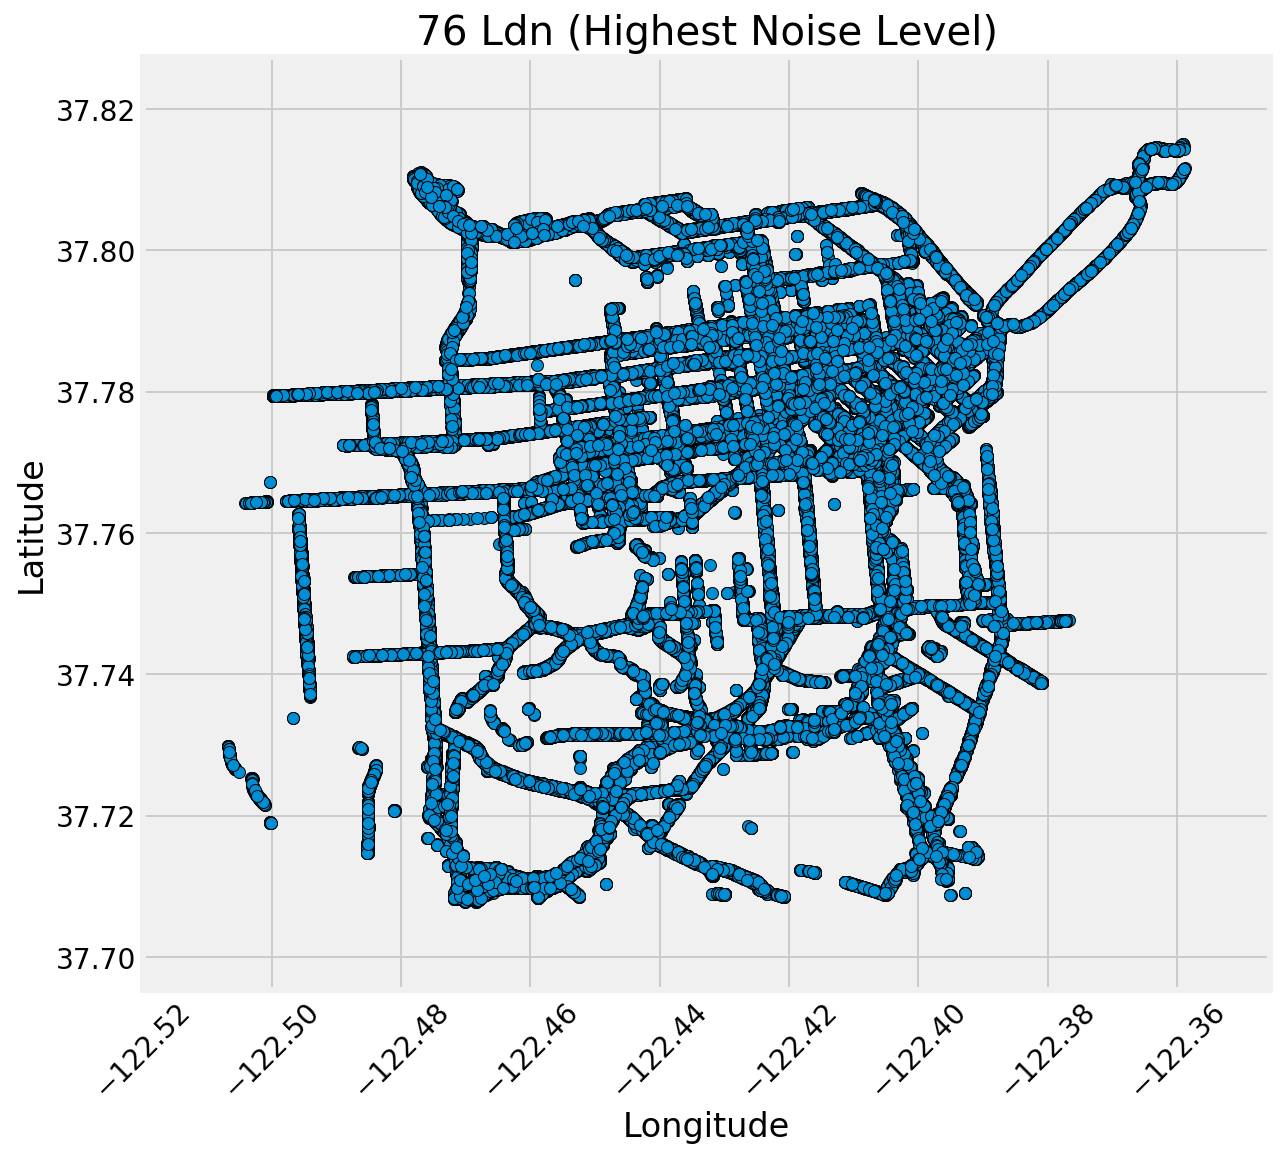

In [94]:
plt.figure(figsize=(9,8), facecolor='w')
plt.scatter(ldn_76[:,0], ldn_76[:,1], edgecolors='k')
plt.xlabel('Longitude')
plt.xticks(rotation=45)
plt.ylabel('Latitude')
plt.title('76 Ldn (Highest Noise Level)')
plt.show();

In [95]:
# This is a function for generating random points within polygons...
# It works pretty well, but I'm going to used just the polygon outline points for now

# import random
# from shapely.geometry import Point
# def generate_random(number, polygon):
#     list_of_points = []
#     minx, miny, maxx, maxy = polygon.bounds
#     counter = 0
#     while counter < number:
#         pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
#         if polygon.contains(pnt):
#             list_of_points.append(pnt)
#             counter += 1
#     return list_of_points

# tmp2 = []
# for item in tmp:
#     tmp2.append([item.xy[0].tolist()[0], item.xy[1].tolist()[0]])

# plt.scatter(np.array(tmp2)[:,0], np.array(tmp2)[:,1])
# plt.xlim((-122.46018, -122.46016))
# plt.ylim((37.73520, 37.73523))
# test.iloc[0].geometry;

## Airbnb preliminary data treatment

The goal is to clean the Airbnb datasets then combine the calendar df (which includes prices) with the listings df and the reviews df. This combined Airbnb dataset will then be used to build, train, and test a preliminary pricing model for rentals.

Much of the data still need to be converted to numeric types. Need to also check if all listing ids match across the various tables. Would be great to do some NLP on the reviews and maybe listing info. I am assuming that the listing info provided by owners is going to be from a rose-colored glasses perspective, but might still be useful.

There is a lot of other information that could be combined with this to make a more robust model, but it will be good to establish a baseline first. Also, there are still somethings that need to be hammered out, like how the prices could changes depending on the date of the rental - for now I may just assign a rental rate that is the mean of all of the prices through the year (i.e. not just a mean of the high and low price but a mean over all of the days the listing is available for rent).

In [96]:
print 'Number or listings ids in "calendar": {}'.format(len(bnb_cal.listing_id.unique()))
print 'Number or listings ids in "listings": {}'.format(len(bnb_listings.id.unique()))
print 'Number or listings ids in "reviews": {}'.format(len(bnb_reviews.listing_id.unique()))


Number or listings ids in "calendar": 8619
Number or listings ids in "listings": 8619
Number or listings ids in "reviews": 6396


It appears that there are not reviews for every listing, this could be because some of them are new listings or people signed up but never actually listed their units. For most of the listings there are many reviews that need to be coalesced for word analysis. Listings that are missing reviews may have never had guests, for one reason or another.

First, I need to deal with the prices from the calendar table, which need to be grouped by id, aggregating the prices by taking the mean for each listing. The listings summary table actually has pricing information for each listing but I want to see if those prices are consistent and take into account the vairable rate that some people charge for their rentals.

In [98]:
bnb_listings_sum.id.unique().shape

(8619,)

In [99]:
cal_mean_prices = bnb_cal.groupby("listing_id")[["price"]].mean()
cal_mean_prices.reset_index(inplace=True)
cal_mean_prices.tail()

listing_id      price
8614    13801466  55.000000
8615    13802849  61.071429
8616    13802856  75.000000
8617    13803228        NaN
8618    13803588  60.000000

In [100]:
bnb_listings_sum[bnb_listings_sum.id == 13803228]

id                          name   host_id host_name  \
1037  13803228  Fab Mid-Century Master Suite  79745762      Troy   

      neighbourhood_group    neighbourhood   latitude   longitude  \
1037                  NaN  Diamond Heights  37.746253 -122.444623   

         room_type  price  minimum_nights  number_of_reviews last_review  \
1037  Private room    195               2                  0         NaN   

      reviews_per_month  calculated_host_listings_count  availability_365  
1037                NaN                               1                 0

Some of the units that don't have any prices listed in the calendar have prices given in the listings summary table. Need to decide what to do about this - it's pretty clear that people may have stopped making their units available for rent (missing from calendar availibility) even though they still have a rental profile/summary available in the listings summary table.

In [101]:
bnb_listings.head(3)

id                            listing_url       scrape_id  \
0  11187767  https://www.airbnb.com/rooms/11187767  20160702162156   
1   6938818   https://www.airbnb.com/rooms/6938818  20160702162156   
2   9395222   https://www.airbnb.com/rooms/9395222  20160702162156   

  last_scraped                                name  \
0   2016-07-02  Huge Seacliff Penthouse With Views   
1   2016-07-02                 Best Secret in Town   
2   2016-07-02       Ocean Beach, Lands End Escape   

                                             summary  \
0  Amazing views from this immense 3 bedroom/ 2 b...   
1  My two story house is located in the quite sid...   
2  Come relax in our 1 bedroom 1 bath house minut...   

                                               space  \
0  Spacious patio deck, library with over 300 mov...   
1  The room is spacious and it is on the top leve...   
2  Huge backyard with a FirePit and lounge chairs...   

                                         description experiences_offered  \
0  Amazing views from this immense 3 bedroom/ 2 b...                none   
1  My two story house is located in the quite sid...                none   
2  Come relax in our 1 bedroom 1 bath house minut...                none   

                               neighborhood_overview        ...          \
0  The neighborhood includes Legion of Honor, Sut...        ...           
1  It is in the city and close to everything. Par...        ...           
2                                                NaN        ...           

  review_scores_value requires_license  \
0                 8.0                t   
1                 9.0                t   
2                 9.0                t   

                                             license jurisdiction_names  \
0                                                NaN      SAN FRANCISCO   
1  S. F. Short-Term Residential Rental Registrati...      SAN FRANCISCO   
2                                                NaN      SAN FRANCISCO   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                t              strict                             f   
1                f              strict                             f   
2                t              strict                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              2   
2                                f                              1   

   reviews_per_month  
0               0.88  
1               1.85  
2               5.87  

[3 rows x 95 columns]

Merge summary table with the prices calculated from the calendar table.

In [102]:
cal_sum = bnb_listings_sum.merge(cal_mean_prices, left_on="id", right_on="listing_id", how='left')
cal_sum['price_mod'] = cal_sum.price_y.values
cal_sum.price_mod.fillna(cal_sum['price_x'], inplace=True)
price_cut = cal_sum[['id', 'price_y', 'price_mod']]
cal_sum.head(1)

id                                name   host_id host_name  \
0  11187767  Huge Seacliff Penthouse With Views  58242037  Jonathan   

   neighbourhood_group neighbourhood   latitude   longitude        room_type  \
0                  NaN      Seacliff  37.779685 -122.510472  Entire home/apt   

   price_x  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0      400               2                  3  2016-06-25               0.88   

   calculated_host_listings_count  availability_365  listing_id     price_y  \
0                               1               152    11187767  497.368421   

    price_mod  
0  497.368421

Almost all of the columns from the summary table are present in the listings table already. Therefore, I can extract the two price columns (including the one I created) and merge them with the full listings table.

In [103]:
# Rename columns so they don't have prefix - could do this more efficiently with regex...

room_type = bnb_listings[['id', 'room_type']]
room_type = pd.get_dummies(room_type, columns=['room_type'])
room_type.rename(columns={"room_type_Entire home/apt": 'entire_home_apt', 'room_type_Private room': 'private_room',
                          'room_type_Shared room': 'shared_room'}, inplace=True)

prop_type = bnb_listings[['id', 'property_type']]
prop_type = pd.get_dummies(prop_type, columns=['property_type'])
prop_type.rename(columns={'property_type_Apartment': 'apartment', 'property_type_Bed & Breakfast': 'bed_breakfast',
                          'property_type_Boat': 'boat', 'property_type_Bungalow': 'bungalow', 
                          'property_type_Cabin': 'cabin', 'property_type_Camper/RV': 'camper_rv', 
                          'property_type_Castle': 'castle', 'property_type_Cave': 'cave', 
                          'property_type_Condominium': 'codominium', 'property_type_Dorm': 'dorm', 
                          'property_type_House': 'house', 'property_type_Lighthouse': 'lighthouse', 
                          'property_type_Loft': 'loft', 'property_type_Other': 'other', 
                          'property_type_Tent': 'tent', 'property_type_Townhouse': 'townhouse', 
                          'property_type_Treehouse': 'treehouse', 'property_type_Villa': 'villa', 
                          'property_type_Yurt': 'yurt'}, inplace=True)

In [107]:
# Merge modified prices into new, full dataframe and fill NaN columns with 0

bnb_list_full = bnb_listings.merge(price_cut, on='id', how='left')
bnb_list_full = bnb_list_full.merge(room_type, on='id', how='left')
bnb_list_full = bnb_list_full.merge(prop_type, on='id', how='left')
bnb_list_full.review_scores_rating.fillna(bnb_list_full.review_scores_rating.mean(), inplace=True)
bnb_list_full.review_scores_accuracy.fillna(bnb_list_full.review_scores_accuracy.mean(), inplace=True)
bnb_list_full.review_scores_cleanliness.fillna(bnb_list_full.review_scores_cleanliness.mean(), inplace=True)
bnb_list_full.review_scores_checkin.fillna(bnb_list_full.review_scores_checkin.mean(), inplace=True)
bnb_list_full.review_scores_communication.fillna(bnb_list_full.review_scores_communication.mean(), inplace=True)
bnb_list_full.review_scores_location.fillna(bnb_list_full.review_scores_location.mean(), inplace=True)
bnb_list_full.review_scores_value.fillna(bnb_list_full.review_scores_value.mean(), inplace=True)

bnb_list_full.head(1)

id                            listing_url       scrape_id  \
0  11187767  https://www.airbnb.com/rooms/11187767  20160702162156   

  last_scraped                                name  \
0   2016-07-02  Huge Seacliff Penthouse With Views   

                                             summary  \
0  Amazing views from this immense 3 bedroom/ 2 b...   

                                               space  \
0  Spacious patio deck, library with over 300 mov...   

                                         description experiences_offered  \
0  Amazing views from this immense 3 bedroom/ 2 b...                none   

                               neighborhood_overview  ...  dorm house  \
0  The neighborhood includes Legion of Honor, Sut...  ...     0     0   

  lighthouse loft other tent townhouse treehouse villa  yurt  
0          0    0     0    0         0         0     0     0  

[1 rows x 119 columns]

Need to convert some of the money features into float data types. Function from above is used to convert the dollar columns to floats.

In [109]:
bnb_list_full = conv_dollars(bnb_list_full, ['price', 'weekly_price', 'monthly_price', 
                                             'security_deposit', 'cleaning_fee', 'extra_people'])


Could use bed_type and amenities if I wanted to generate more features from categorical values. Converted room_type and proper_type to categorical feature columns with boolean values. This could possibly be restructured with a different method or changed to a more appropriate method that takes into account for categories that are rare (sparse columns when using boolean values).

Square_feet would be a great predictor to use, and will likely be availabe with real estate listings, should consider this a large caveat.

Some listings have never been reviewed, which represents a bit of a challenge considering they are valueable pieces of data I don't want to simply discard. For now I will impute mean rating values for each column into missing values (NaNs).

There are also 4 or 5 listings that I know are fake and have large prices that are probably throwing off the model. I am going to cut these out by their listing_id.

In [110]:
# used this for finding fake listings and other outliers in the dataset
bnb_list_full[bnb_list_full['summary'].str.contains(r"fake", na=False)]

id                           listing_url       scrape_id  \
2376  9939073  https://www.airbnb.com/rooms/9939073  20160702162156   

     last_scraped           name                     summary space  \
2376   2016-07-02  fake booking!  don't stay here it's fake!   NaN   

                     description experiences_offered neighborhood_overview  \
2376  don't stay here it's fake!                none                   NaN   

      ...  dorm house lighthouse loft other tent townhouse treehouse villa  \
2376  ...     0     0          0    0     0    0         0         0     0   

      yurt  
2376     0  

[1 rows x 119 columns]

In [111]:
# These are a collection of fake listings and other rentals that are extreme outliers
fake_listings = [2417349, 13187104, 13086674, 10724176,  11671456, 8614819,
                 12756507, 10929043, 11993313, 900485, 8703269, 9939073, 13205424, 
                 8353194, 5241594, 10926089, 9978975, 10926823, 7181467, 12605137, 
                 10962521, 9394422, 8993733, 2970867, 9880181, 10766464, 10854509, 
                 10840730, 1961076, 6492391, 10920486, 11023311, 10206402,11046897, 
                 10769149, 10846683, 8257534, 10383517, 10917847, 10836765, 10910661, 
                 11085405, 9280852, 1332629, 10923676, 10900338, 10879152, 10073786, 
                 10880931, 10931258, 11014352, 10766524, 10889013, 935967, 10553331, 
                 9342219, 10930264, 10811617, 10998170, 10788444]

for item in fake_listings:
    bnb_list_full = bnb_list_full[bnb_list_full.id != item]

In [112]:
bnb_list_full.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms',

In [113]:
# Make list of all numeric columns to include in the final baseline Airbnb dataset

num_cols = ['id','host_total_listings_count','latitude', 'longitude', 'accommodates', 'bathrooms',
            'bedrooms', 'beds', 'amenities', 'price','guests_included', 'extra_people', 
            'minimum_nights','maximum_nights',
            'availability_30', 'availability_60', 'availability_90', 'availability_365', 
            'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 
            'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 
            'reviews_per_month', 'price_y', 'price_mod', 'entire_home_apt', 'private_room', 
            'shared_room', 'apartment', 'bed_breakfast', 'boat', 'bungalow', 'cabin',
            'camper_rv', 'castle', 'cave', 'codominium', 'dorm', 'house','lighthouse', 'loft', 
            'other', 'tent', 'townhouse', 'treehouse', 'villa', 'yurt']
bnb_list_full =  bnb_list_full[num_cols + ['neighbourhood_cleansed']]


One hot encode neighbourhood_cleansed feature.

In [114]:
neigh_dummies = pd.get_dummies(bnb_list_full.neighbourhood_cleansed)
bnb_list_full = pd.concat([bnb_list_full[num_cols], neigh_dummies], axis=1)

In [115]:
bnb_list_full.head()

id  host_total_listings_count   latitude   longitude  accommodates  \
0  11187767                        1.0  37.779685 -122.510472             6   
1   6938818                        2.0  37.780659 -122.505635             4   
2   9395222                        2.0  37.781433 -122.505179             4   
3   8388658                        1.0  37.787664 -122.489152             6   
4   7856443                        2.0  37.782133 -122.492730             6   

   bathrooms  bedrooms  beds  \
0        2.0       3.0   3.0   
1        1.0       1.0   2.0   
2        1.0       1.0   2.0   
3        2.5       3.0   4.0   
4        2.5       3.0   4.0   

                                           amenities  price        ...         \
0  {TV,"Cable TV","Wireless Internet",Kitchen,Hea...  400.0        ...          
1  {TV,Internet,"Wireless Internet",Kitchen,Heati...   99.0        ...          
2  {TV,Kitchen,"Free Parking on Premises","Pets A...  155.0        ...          
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...  895.0        ...          
4  {TV,Internet,"Wireless Internet",Kitchen,"Free...  195.0        ...          

   Presidio  Presidio Heights  Russian Hill  Seacliff  South of Market  \
0         0                 0             0         1                0   
1         0                 0             0         1                0   
2         0                 0             0         1                0   
3         0                 0             0         1                0   
4         0                 0             0         1                0   

   Treasure Island/YBI  Twin Peaks  Visitacion Valley  West of Twin Peaks  \
0                    0           0                  0                   0   
1                    0           0                  0                   0   
2                    0           0                  0                   0   
3                    0           0                  0                   0   
4                    0           0                  0                   0   

   Western Addition  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 89 columns]

Fill some missing values with logical replacements.
    
- 2 missing from host_total_listings_count - replace with 1
- 48 missing from bathrooms - replace with 1, considering there is likely a bathroom somewhere
- 6 missing from bedrooms - replace with 0, there probably isn't an actual bed, maybe something to sleep on
- 10 missing from beds - replace with 1, there is probably somewhere to sleep, but maybe not much
- 8417 missing from square_feet - removed feature - would certainly be useful in actual real estate listings
- 2223 missing from reviews_per_month - replace with 0, since there are probably no or very few reviews

In [116]:
bnb_list_full.host_total_listings_count.fillna(1, inplace=True)
bnb_list_full.bathrooms.fillna(0, inplace=True)
bnb_list_full.bedrooms.fillna(0, inplace=True)
#bnb_list_full.beds.dropna(inplace=True)
bnb_list_full = bnb_list_full[bnb_list_full.beds > 0]
bnb_list_full = bnb_list_full[bnb_list_full.bedrooms > 0]
# bnb_list_full[[x for x in bnb_list_full.columns.values if x != 'square_feet']]
bnb_list_full.reviews_per_month.fillna(0, inplace=True)
#bnb_list_full[bnb_list_full.beds == 0].beds.value_counts()

In [117]:
print bnb_list_full.shape

(7911, 89)


Neighborhood has a lot to do with the pricing of listings. In order to use this information, I am assigning the census track where each property is located and then I will use the median income for that census track as a new predictor.

In [118]:
bnb_list_full_geo = gpd.GeoDataFrame(bnb_list_full, geometry=bnb_list_full.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))
bnb_list_full_geo['census_tract'] = bnb_list_full_geo.apply(assign_census_tract, axis='columns')
bnb_list_full_geo.head()


id  host_total_listings_count   latitude   longitude  accommodates  \
0  11187767                        1.0  37.779685 -122.510472             6   
1   6938818                        2.0  37.780659 -122.505635             4   
2   9395222                        2.0  37.781433 -122.505179             4   
3   8388658                        1.0  37.787664 -122.489152             6   
4   7856443                        2.0  37.782133 -122.492730             6   

   bathrooms  bedrooms  beds  \
0        2.0       3.0   3.0   
1        1.0       1.0   2.0   
2        1.0       1.0   2.0   
3        2.5       3.0   4.0   
4        2.5       3.0   4.0   

                                           amenities  price      ...       \
0  {TV,"Cable TV","Wireless Internet",Kitchen,Hea...  400.0      ...        
1  {TV,Internet,"Wireless Internet",Kitchen,Heati...   99.0      ...        
2  {TV,Kitchen,"Free Parking on Premises","Pets A...  155.0      ...        
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...  895.0      ...        
4  {TV,Internet,"Wireless Internet",Kitchen,"Free...  195.0      ...        

   Russian Hill  Seacliff  South of Market  Treasure Island/YBI  Twin Peaks  \
0             0         1                0                    0           0   
1             0         1                0                    0           0   
2             0         1                0                    0           0   
3             0         1                0                    0           0   
4             0         1                0                    0           0   

   Visitacion Valley  West of Twin Peaks  Western Addition  \
0                  0                   0                 0   
1                  0                   0                 0   
2                  0                   0                 0   
3                  0                   0                 0   
4                  0                   0                 0   

                                       geometry  census_tract  
0  POINT (-122.5104716962268 37.77968470054454)        479.01  
1  POINT (-122.5056347793022 37.78065902049909)        479.02  
2  POINT (-122.5051793274895 37.78143337110802)          9802  
3   POINT (-122.489152227618 37.78766423088835)           428  
4  POINT (-122.4927302695125 37.78213277410354)           427  

[5 rows x 91 columns]

In [120]:
bnb_list_full_geo = bnb_list_full_geo[bnb_list_full_geo.census_tract.notnull()]
bnb_list_full_geo['census_tract'] = pd.to_numeric(bnb_list_full_geo.census_tract)
bnb_list_full_geo['med_fam_inc_est16'] = bnb_list_full_geo['census_tract'].map(inc_dict)
bnb_list_full_geo['percent_below_poverty'] = bnb_list_full_geo['census_tract'].map(poverty_dict)
bnb_list_full_geo.head(3)

id  host_total_listings_count   latitude   longitude  accommodates  \
0  11187767                        1.0  37.779685 -122.510472             6   
1   6938818                        2.0  37.780659 -122.505635             4   
2   9395222                        2.0  37.781433 -122.505179             4   

   bathrooms  bedrooms  beds  \
0        2.0       3.0   3.0   
1        1.0       1.0   2.0   
2        1.0       1.0   2.0   

                                           amenities  price  \
0  {TV,"Cable TV","Wireless Internet",Kitchen,Hea...  400.0   
1  {TV,Internet,"Wireless Internet",Kitchen,Heati...   99.0   
2  {TV,Kitchen,"Free Parking on Premises","Pets A...  155.0   

           ...            South of Market  Treasure Island/YBI  Twin Peaks  \
0          ...                          0                    0           0   
1          ...                          0                    0           0   
2          ...                          0                    0           0   

   Visitacion Valley  West of Twin Peaks  Western Addition  \
0                  0                   0                 0   
1                  0                   0                 0   
2                  0                   0                 0   

                                       geometry  census_tract  \
0  POINT (-122.5104716962268 37.77968470054454)        479.01   
1  POINT (-122.5056347793022 37.78065902049909)        479.02   
2  POINT (-122.5051793274895 37.78143337110802)       9802.00   

   med_fam_inc_est16  percent_below_poverty  
0           100428.0                   4.51  
1            92366.0                   8.63  
2           278492.0                  10.33  

[3 rows x 93 columns]

In [121]:
bnb_list_full_geo = pd.DataFrame(bnb_list_full_geo)
pd.to_pickle(bnb_list_full_geo, './bnb_list_full_geo')

In [64]:
bnb_list_full_geo = pd.read_pickle('./bnb_list_full_geo')

In [122]:
pd.to_pickle(bnb_list_full, './bnb_list_full')

In [66]:
bnb_list_full = pd.read_pickle('./bnb_list_full')

Plot map of all Airbnb rental units.

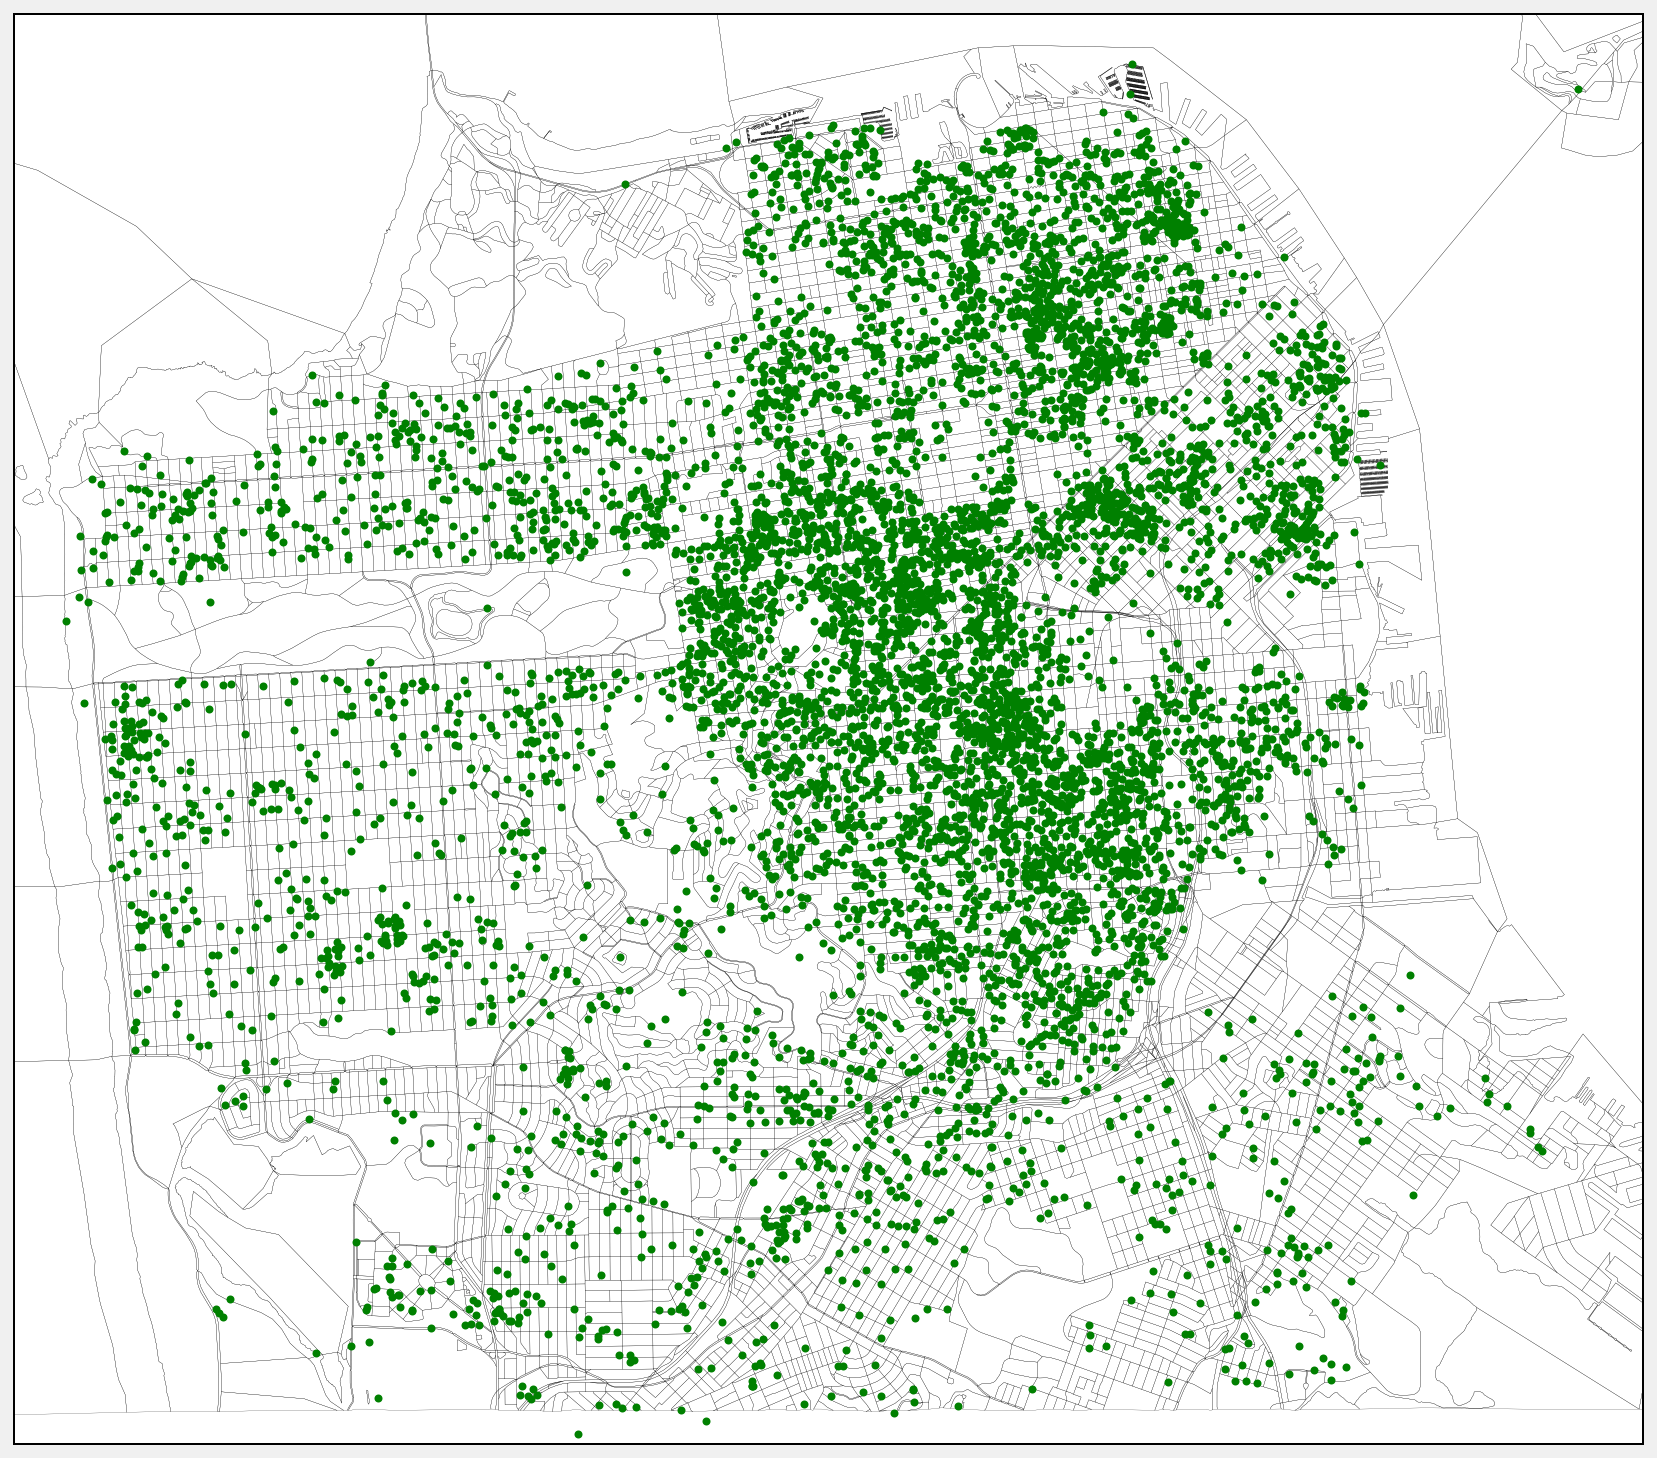

In [125]:
y = bnb_list_full.latitude.values
x = bnb_list_full.longitude.values

plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.1)

m.drawmapboundary(fill_color='white')

m.plot(x, y, 'go', markersize=3, latlon=True)
#plt.savefig('abnb_map.pdf')
plt.show()

It is important to mention that Airbnb anonymizes rental locations by changing them slightly. Overall, the coordinates given are supposedly no more 500 ft or so from the actual location, so it shouldn't matter too much for our analysis. Although, this could create unexpected or unintended interactions witht the geospatial city data.

## 311 Data treatment

There's quite a bit of 311 data going back to 2008 or so. Will need to filter so that I only have the last couple of years, and also figure out a method for treating the categorical data. NB: the filename prefix is 'rec' for records.

***The majority of this analysis and editing of the 311 data is done in the other preliminary model notebook - This is the place where the place where three of the columns are converted to datetime types and resaved to a pickle file***

In [151]:
import datetime

In [152]:
rec_311.shape

(1821839, 16)

The date-type columns need to be converted to the datetime datatype so they can be more easily filtered. This is very time consuming, so the resulting dataframe is pickled for further use in this notebook or others.

In [171]:
# rec_311['Opened'] = pd.to_datetime(rec_311.Opened, infer_datetime_format=True)
# rec_311['Closed'] = pd.to_datetime(rec_311.Closed, infer_datetime_format=True)
# rec_311['Updated'] = pd.to_datetime(rec_311.Updated, infer_datetime_format=True)

In [154]:
#pd.to_pickle(rec_311, '../ga_project_data/rec_311_dt')

In [100]:
rec_311_dt = pd.read_pickle('../ga_project_data/rec_311_dt')

In [101]:
rec_311_dt.head(3)

CaseID              Opened              Closed             Updated  Status  \
0  322571 2008-11-30 23:53:00 2008-11-30 23:53:00 2008-11-30 23:53:00  Closed   
1  322568 2008-11-30 23:13:00 2008-11-30 23:13:00 2008-11-30 23:13:00  Closed   
2  322567 2008-11-30 23:07:00 2008-11-30 23:07:00 2008-11-30 23:07:00  Closed   

  Status Notes        Responsible Agency          Category  \
0          NaN  PUC - Electric/Power - G  General Requests   
1          NaN             DPW Ops Queue  Illegal Postings   
2          NaN             DPW Ops Queue  Illegal Postings   

                                   Request Type  \
0          puc - electric - request_for_service   
1  Illegal Postings - Posting_Too_Large_in_Size   
2         Illegal Postings - Affixed_Improperly   

                         Request Details  \
0   puc - electric - request_for_service   
1  Posting_Too_Large_in_Size on Sidewalk   
2         Affixed_Improperly on Sidewalk   

                                      Address  Supervisor District  \
0         Intersection of 21ST ST and CAPP ST                    9   
1    Intersection of BUSH ST and VAN NESS AVE                    3   
2  Intersection of EUCLID AVE and MASONIC AVE                    2   

       Neighborhood                                  Point    Source Media URL  
0           Mission  (37.7571008516766, -122.417811874214)  Voice In       NaN  
1          Nob Hill  (37.7884895281133, -122.421948485141)  Voice In       NaN  
2  Western Addition  (37.7850837365507, -122.447620029034)  Voice In       NaN

Sort the 311 datasets so that only data from 2015 and onwards are included - this still leaves plenty of data, but makes it more applicable (and also easier to handle).

In [102]:
print max(rec_311_dt.Opened)
print min(rec_311_dt.Opened)

2016-08-11 00:57:07
2008-03-20 11:48:32


In [142]:
rec_15up = rec_311_dt[rec_311_dt.Opened >= datetime.datetime(2015, 1, 1)]
rec_15up = rec_15up[rec_15up.Point.notnull()]
print rec_15up.shape
rec_15up

(577777, 16)


CaseID              Opened              Closed             Updated  \
3164     5012422 2015-08-19 08:00:55 2015-08-19 08:00:55 2015-08-19 08:00:55   
29136    5450427 2016-01-10 10:38:11 2016-01-10 10:38:11 2016-01-10 10:38:11   
48969    5050169 2015-08-31 09:02:50 2015-08-31 09:02:50 2015-08-31 09:02:50   
49384    5085637 2015-09-10 15:57:17 2015-09-10 15:57:17 2015-09-10 15:57:17   
49406    5451524 2016-01-10 18:39:10 2016-01-10 18:39:10 2016-01-10 18:39:10   
50545    5128084 2015-09-24 11:51:51 2015-09-24 11:51:51 2015-09-24 11:51:51   
51249    5148575 2015-09-30 23:07:12 2015-09-30 23:07:12 2015-09-30 23:07:12   
58723    4682131 2015-04-20 23:57:29 2015-04-20 23:57:29 2015-04-20 23:57:29   
58817    4682130 2015-04-20 23:55:44 2015-04-20 23:55:44 2015-04-20 23:55:44   
61335    4906656 2015-07-14 08:16:16 2015-07-14 08:16:16 2015-07-14 08:16:16   
61426    4906657 2015-07-14 08:16:24 2015-07-14 08:16:24 2015-07-14 08:16:24   
61542    4906661 2015-07-14 08:17:01 2015-07-14 08:17:01 2015-07-14 08:17:01   
62168    5411325 2015-12-28 17:31:08 2015-12-28 17:31:08 2015-12-28 17:31:08   
65772    4906662 2015-07-14 08:17:47 2015-07-14 08:17:47 2015-07-14 08:17:47   
65856    4906664 2015-07-14 08:17:48 2015-07-14 08:17:48 2015-07-14 08:17:48   
66265    5085299 2015-09-10 14:35:51 2015-09-10 14:35:51 2015-09-10 14:35:51   
66440    5444713 2016-01-08 09:14:41 2016-01-08 09:14:41 2016-01-08 09:14:41   
66658    5449573 2016-01-09 18:42:22 2016-01-09 18:42:22 2016-01-09 18:42:22   
68204    5450261 2016-01-10 09:23:45 2016-01-10 09:23:45 2016-01-10 09:23:45   
70162    5110636 2015-09-19 07:42:52 2015-09-19 07:42:52 2015-09-19 07:42:52   
70332    4906669 2015-07-14 08:20:18 2015-07-14 08:20:18 2015-07-14 08:20:18   
72201    4906672 2015-07-14 08:20:46 2015-07-14 08:20:46 2015-07-14 08:20:46   
72873    4906676 2015-07-14 08:21:52 2015-07-14 08:21:52 2015-07-14 08:21:52   
74723    5085315 2015-09-10 14:38:19 2015-09-10 14:38:19 2015-09-10 14:38:19   
75171    4972358 2015-08-06 08:03:49 2015-08-06 08:03:49 2015-08-06 08:03:49   
80837    5085318 2015-09-10 14:38:59 2015-09-10 14:38:59 2015-09-10 14:38:59   
84615    4922995 2015-07-20 08:26:30 2015-07-20 08:26:30 2015-07-20 08:26:30   
84630    5525078 2016-02-01 14:43:08 2016-02-01 14:43:08 2016-02-01 14:43:08   
85404    4973344 2015-08-06 13:28:52 2015-08-06 13:28:52 2015-08-06 13:28:52   
85738    4978185 2015-08-08 07:58:54 2015-08-08 07:58:54 2015-08-08 07:58:54   
...          ...                 ...                 ...                 ...   
1821089  5661443 2016-03-13 20:49:16 2016-03-13 20:49:16 2016-03-13 20:49:16   
1821090  5661450 2016-03-13 20:51:39 2016-03-13 20:51:39 2016-03-13 20:51:39   
1821092  5661481 2016-03-13 21:15:34 2016-03-13 21:15:34 2016-03-13 21:15:34   
1821093  5661488 2016-03-13 21:24:05 2016-03-13 21:24:05 2016-03-13 21:24:05   
1821094  5661445 2016-03-13 20:50:27 2016-03-13 20:50:27 2016-03-13 20:50:27   
1821095  5661442 2016-03-13 20:48:21 2016-03-13 20:48:21 2016-03-13 20:48:21   
1821096  5661495 2016-03-13 21:34:16 2016-03-13 21:34:16 2016-03-13 21:34:16   
1821097  5661507 2016-03-13 21:41:19 2016-03-13 21:41:19 2016-03-13 21:41:19   
1821098  5661505 2016-03-13 21:40:50 2016-03-13 21:40:50 2016-03-13 21:40:50   
1821099  5661518 2016-03-13 21:48:31 2016-03-13 21:48:31 2016-03-13 21:48:31   
1821100  5661523 2016-03-13 21:50:03 2016-03-13 21:50:03 2016-03-13 21:50:03   
1821101  5661539 2016-03-13 21:58:40 2016-03-13 21:58:40 2016-03-13 21:58:40   
1821102  5661544 2016-03-13 22:00:38 2016-03-13 22:00:38 2016-03-13 22:00:38   
1821103  5661548 2016-03-13 22:02:03 2016-03-13 22:02:03 2016-03-13 22:02:03   
1821104  5661550 2016-03-13 22:02:42 2016-03-13 22:02:42 2016-03-13 22:02:42   
1821105  5661552 2016-03-13 22:03:26 2016-03-13 22:03:26 2016-03-13 22:03:26   
1821106  5661553 2016-03-13 22:03:49 2016-03-13 22:03:49 2016-03-13 22:03:49   
1821107  5661543 2016-03-13 22:00:16 2016-03-13 22:00:16 2016-03-13 22:00:16   
1821108  5

Add or modify some of the features, inlcuding:

- Delete all of the requests (rows) with no 'Point', i.e. Lat/Long (DONE ABOVE)
- Expand the 'Point' feature, Lat/Long, into two more columns, 'latitude' and 'longitude'
- Create groups of categories for 'Category' feature, then dummy encode the grouped categories for each request
- Could clean the dataframe of all the requests where there was no reponse. These cases are typically closed immediately by the city or by the person who submitted the request
- (Might be tricky given different categories) create a time delta for the time it takes for requests to be closed after opening

In [143]:
rec_15up['latitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[0])
rec_15up['longitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[1])
#rec_15up['latitude'] = rec_15up.Point.apply(lambda x: x)
#rec_15up['longitude'] = rec_15up.Point.apply(lambda x: x[1])
rec_15up

CaseID              Opened              Closed             Updated  \
3164     5012422 2015-08-19 08:00:55 2015-08-19 08:00:55 2015-08-19 08:00:55   
29136    5450427 2016-01-10 10:38:11 2016-01-10 10:38:11 2016-01-10 10:38:11   
48969    5050169 2015-08-31 09:02:50 2015-08-31 09:02:50 2015-08-31 09:02:50   
49384    5085637 2015-09-10 15:57:17 2015-09-10 15:57:17 2015-09-10 15:57:17   
49406    5451524 2016-01-10 18:39:10 2016-01-10 18:39:10 2016-01-10 18:39:10   
50545    5128084 2015-09-24 11:51:51 2015-09-24 11:51:51 2015-09-24 11:51:51   
51249    5148575 2015-09-30 23:07:12 2015-09-30 23:07:12 2015-09-30 23:07:12   
58723    4682131 2015-04-20 23:57:29 2015-04-20 23:57:29 2015-04-20 23:57:29   
58817    4682130 2015-04-20 23:55:44 2015-04-20 23:55:44 2015-04-20 23:55:44   
61335    4906656 2015-07-14 08:16:16 2015-07-14 08:16:16 2015-07-14 08:16:16   
61426    4906657 2015-07-14 08:16:24 2015-07-14 08:16:24 2015-07-14 08:16:24   
61542    4906661 2015-07-14 08:17:01 2015-07-14 08:17:01 2015-07-14 08:17:01   
62168    5411325 2015-12-28 17:31:08 2015-12-28 17:31:08 2015-12-28 17:31:08   
65772    4906662 2015-07-14 08:17:47 2015-07-14 08:17:47 2015-07-14 08:17:47   
65856    4906664 2015-07-14 08:17:48 2015-07-14 08:17:48 2015-07-14 08:17:48   
66265    5085299 2015-09-10 14:35:51 2015-09-10 14:35:51 2015-09-10 14:35:51   
66440    5444713 2016-01-08 09:14:41 2016-01-08 09:14:41 2016-01-08 09:14:41   
66658    5449573 2016-01-09 18:42:22 2016-01-09 18:42:22 2016-01-09 18:42:22   
68204    5450261 2016-01-10 09:23:45 2016-01-10 09:23:45 2016-01-10 09:23:45   
70162    5110636 2015-09-19 07:42:52 2015-09-19 07:42:52 2015-09-19 07:42:52   
70332    4906669 2015-07-14 08:20:18 2015-07-14 08:20:18 2015-07-14 08:20:18   
72201    4906672 2015-07-14 08:20:46 2015-07-14 08:20:46 2015-07-14 08:20:46   
72873    4906676 2015-07-14 08:21:52 2015-07-14 08:21:52 2015-07-14 08:21:52   
74723    5085315 2015-09-10 14:38:19 2015-09-10 14:38:19 2015-09-10 14:38:19   
75171    4972358 2015-08-06 08:03:49 2015-08-06 08:03:49 2015-08-06 08:03:49   
80837    5085318 2015-09-10 14:38:59 2015-09-10 14:38:59 2015-09-10 14:38:59   
84615    4922995 2015-07-20 08:26:30 2015-07-20 08:26:30 2015-07-20 08:26:30   
84630    5525078 2016-02-01 14:43:08 2016-02-01 14:43:08 2016-02-01 14:43:08   
85404    4973344 2015-08-06 13:28:52 2015-08-06 13:28:52 2015-08-06 13:28:52   
85738    4978185 2015-08-08 07:58:54 2015-08-08 07:58:54 2015-08-08 07:58:54   
...          ...                 ...                 ...                 ...   
1821089  5661443 2016-03-13 20:49:16 2016-03-13 20:49:16 2016-03-13 20:49:16   
1821090  5661450 2016-03-13 20:51:39 2016-03-13 20:51:39 2016-03-13 20:51:39   
1821092  5661481 2016-03-13 21:15:34 2016-03-13 21:15:34 2016-03-13 21:15:34   
1821093  5661488 2016-03-13 21:24:05 2016-03-13 21:24:05 2016-03-13 21:24:05   
1821094  5661445 2016-03-13 20:50:27 2016-03-13 20:50:27 2016-03-13 20:50:27   
1821095  5661442 2016-03-13 20:48:21 2016-03-13 20:48:21 2016-03-13 20:48:21   
1821096  5661495 2016-03-13 21:34:16 2016-03-13 21:34:16 2016-03-13 21:34:16   
1821097  5661507 2016-03-13 21:41:19 2016-03-13 21:41:19 2016-03-13 21:41:19   
1821098  5661505 2016-03-13 21:40:50 2016-03-13 21:40:50 2016-03-13 21:40:50   
1821099  5661518 2016-03-13 21:48:31 2016-03-13 21:48:31 2016-03-13 21:48:31   
1821100  5661523 2016-03-13 21:50:03 2016-03-13 21:50:03 2016-03-13 21:50:03   
1821101  5661539 2016-03-13 21:58:40 2016-03-13 21:58:40 2016-03-13 21:58:40   
1821102  5661544 2016-03-13 22:00:38 2016-03-13 22:00:38 2016-03-13 22:00:38   
1821103  5661548 2016-03-13 22:02:03 2016-03-13 22:02:03 2016-03-13 22:02:03   
1821104  5661550 2016-03-13 22:02:42 2016-03-13 22:02:42 2016-03-13 22:02:42   
1821105  5661552 2016-03-13 22:03:26 2016-03-13 22:03:26 2016-03-13 22:03:26   
1821106  5661553 2016-03-13 22:03:49 2016-03-13 22:03:49 2016-03-13 22:03:49   
1821107  5661543 2016-03-13 22:00:16 2016-03-13 22:00:16 2016-03-13 22:00:16   
1821108  5

In [144]:
cats_311 = ['Temporary Sign Request', 'Color Curb', 'Graffiti Public Property',
            'Illegal Postings', 'Rec and Park Requests', '311 External Request',
            'General Requests', 'Street and Sidewalk Cleaning', 'Streetlights',
            'SFHA Requests', 'Street Defects', 'Damaged Property',
            'Sewer Issues', 'Litter Receptacles', 'Sign Repair',
            'MUNI Feedback', 'Graffiti Private Property',
            'Catch Basin Maintenance', 'Abandoned Vehicle', 'Tree Maintenance',
            'Sidewalk or Curb', 'Blocked Street or SideWalk',
            'Residential Building Request', 'Noise Report',
            'Interdepartmental Request', 'DPW Volunteer Programs',
            'Unpermitted Cab Complaint', 'Construction Zone Permits']

big_cats_311 = {'repair': ['Streetlights', 'Sewer Issues', 'Sign Repair', 'Sidewalk or Curb'], 
            'graffiti': ['Graffiti Public Property', 'Graffiti Private Property'], 
            'cosmetic': ['Color Curb', 'Illegal Postings', 'Rec and Park Requests', 
                         'Litter Receptacles', 'Tree Maintenance', ], 
            'construction': ['Temporary Sign Request', 'Noise Report', 
                             'Construction Zone Permits'], 
            'street': ['Street and Sidewalk Cleaning', 'Street Defects', 
                       'Catch Basin Maintenance'], 
            'other': ['311 External Request', 'General Requests', 'SFHA Requests', 
                      'Blocked Street or SideWalk', 'Residential Building Request', 
                      'Interdepartmental Request', 'DPW Volunteer Programs', 
                      'Unpermitted Cab Complaint'], 
            'damage': ['Damaged Property'], 
            'muni': ['MUNI Feedback'], 
            'Abandoned Vehicle': ['Abandoned Vehicle']}


In [145]:
rec_15up.Category.value_counts()

Street and Sidewalk Cleaning    225638
Graffiti Public Property         63264
Abandoned Vehicle                39217
Graffiti Private Property        38877
General Requests                 34436
Damaged Property                 16918
Sewer Issues                     16735
Illegal Postings                 15259
MUNI Feedback                    14983
Temporary Sign Request           13167
Streetlights                     12470
Tree Maintenance                 12413
Street Defects                   11987
Sign Repair                      11108
Litter Receptacles               10396
Rec and Park Requests             9611
SFHA Requests                     7523
Sidewalk or Curb                  7400
Blocked Street or SideWalk        6583
Noise Report                      2675
Residential Building Request      2280
311 External Request              1834
Color Curb                        1772
Interdepartmental Request          598
Catch Basin Maintenance            579
DPW Volunteer Programs   

Created imprecise categories for the 311 categories of requests. I think this might be obscuring some of the predictive potential of these categories. Creating dummies for them all would create a large amount of sparse columns, but when we bin the data by Lat/Long we will sum the counts for each category in the given bin.

In [146]:
cat_dummies = pd.get_dummies(rec_15up, columns=['Category'])
cat_dummies.T

3164     \
CaseID                                                                           5012422   
Opened                                                               2015-08-19 08:00:55   
Closed                                                               2015-08-19 08:00:55   
Updated                                                              2015-08-19 08:00:55   
Status                                                                            Closed   
Status Notes                                                             Case Resolved -   
Responsible Agency                         Port Authority - Temporary Sign Request Queue   
Request Type                                 Temporary Sign Request for Corporate_Events   
Request Details                        40 ft zone requested from 09/03/2015 to 09/14/...   
Address                                            1 FERRY PLZ, SAN FRANCISCO, CA, 94111   
Supervisor District                                                                    3   
Neighborhood                                                          Financial District   
Point                                                (37.79519943584, -122.393089418147)   
Source                                                                          Voice In   
Media URL                                                                            NaN   
latitude                                                                         37.7952   
longitude                                                                       -122.393   
Category_311 External Request                                                          0   
Category_Abandoned Vehicle                                                             0   
Category_Blocked Street or SideWalk                                                    0   
Category_Catch Basin Maintenance                                                       0   
Category_Color Curb                                                                    0   
Category_Construction Zone Permits                                                     0   
Category_DPW Volunteer Programs                                                        0   
Category_Damaged Property                                                              0   
Category_General Requests                                                              0   
Category_Graffiti Private Property                                                     0   
Category_Graffiti Public Property                                                      0   
Category_Illegal Postings                                                              0   
Category_Interdepartmental Request                                                     0   
Category_Litter Receptacles                                                            0   
Category_MUNI Feedback                                                                 0   
Category_Noise Report                                                                  0   
Category_Rec and Park Requests                                                         0   
Category_Residential Building Request                                                  0   
Category_SFHA Requests                                                                 0   
Category_Sewer Issues                                                                  0   
Category_Sidewalk or Curb                                                              0   
Category_Sign Repair                                                                   0   
Category_Street Defects                                                                0   
Category_Street and Sidewalk Cleaning                                                  0   
Category_Streetlights                                                                  0   
Category_Temporary Sign Request                                                        1   
Category_Tree Maintenance        

In [147]:
cat_dummies.shape

(577777, 45)

A plot of just a sample of the 311 requests.

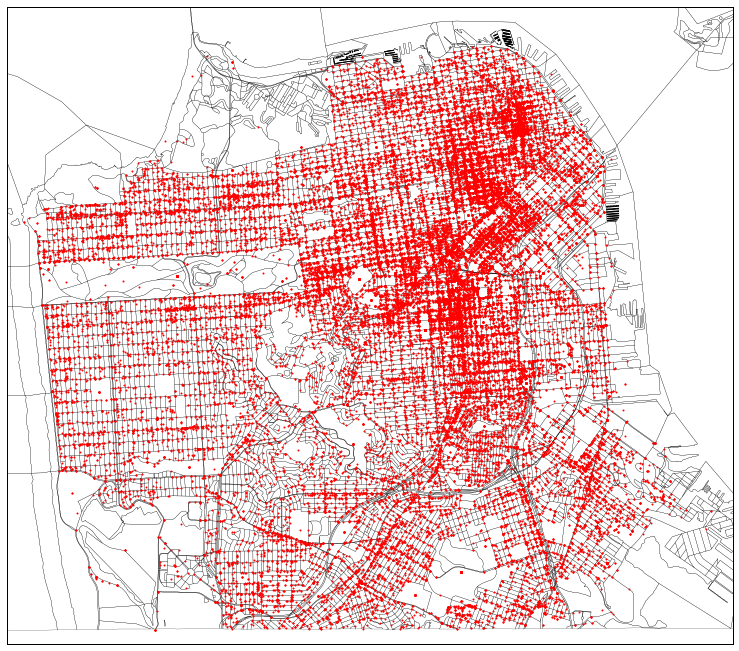

In [149]:
y = cat_dummies.latitude.values[:50000]
x = cat_dummies.longitude.values[:50000]

plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.2)

m.drawmapboundary(fill_color='white')

m.plot(x, y, 'ro', markersize=2, latlon=True)
#plt.title('contour lines over filled continent background')
plt.show()

Could also try using sklearn Kernal Density estimator - http://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


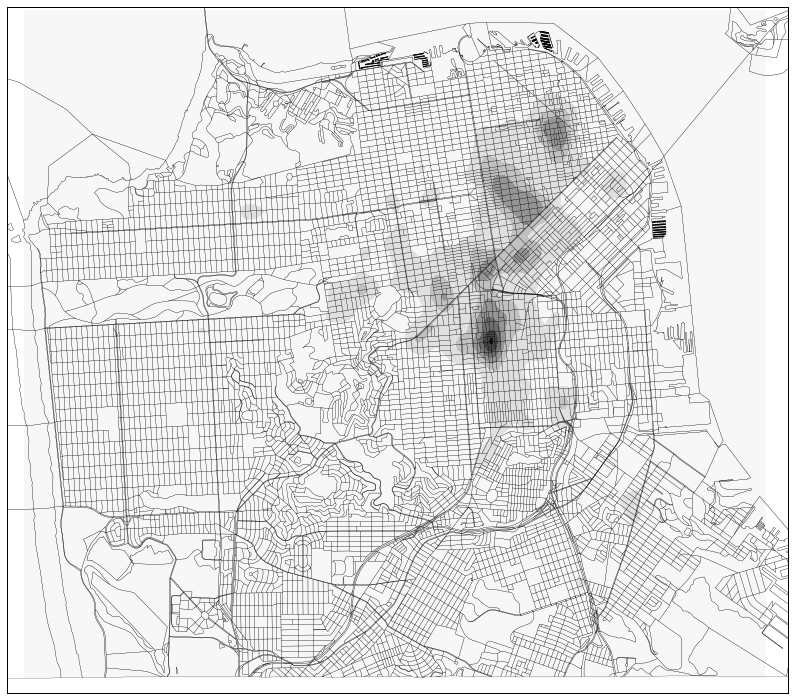

In [150]:
from scipy.stats.kde import gaussian_kde
# For heat map use gaussian kde and into mesh grid
k = gaussian_kde(np.vstack([x, y]), bw_method=0.05)
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

plt.figure(figsize=(14,14))
# Lat/long for corners of map pulled from google maps
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')
m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.2)
m.drawmapboundary(fill_color='white')
m.contourf(xi, yi, zi, latlon=True, )
# plot dots
#m.plot(x, y, 'bo', markersize=1, latlon=True)
plt.show()

## Crime data treatment

Similar to the 311 datasets, this crime data table is edited and modified in the other notebook - mostly in the same ways as below.

In [155]:
#crimes_sf['Date'] = pd.to_datetime(crimes_sf.Date)

In [157]:
#pd.to_pickle(crimes_sf, '../ga_project_data/crimes_sf_dt')

In [158]:
crimes_sf_dt = pd.read_pickle('../ga_project_data/crimes_sf_dt')
crimes_sf_dt.head()

IncidntNum        Category                     Descript DayOfWeek  \
0   110914565        WARRANTS               WARRANT ARREST    Friday   
1    11351210  MISSING PERSON                 FOUND PERSON   Tuesday   
2   120789988  MISSING PERSON                 FOUND PERSON    Monday   
3   140608681         ROBBERY        ROBBERY, BODILY FORCE  Thursday   
4   140608681  OTHER OFFENSES  VIOLATION OF MUNICIPAL CODE  Thursday   

        Date   Time PdDistrict      Resolution                      Address  \
0 2015-05-29  16:42   SOUTHERN  ARREST, BOOKED           BRYANT ST / 8TH ST   
1 2016-06-14  08:55    BAYVIEW            NONE         1200 Block of 3RD ST   
2 2016-05-16  00:41  INGLESIDE            NONE   WOOLSEY ST / UNIVERSITY ST   
3 2016-06-16  21:00   SOUTHERN  ARREST, BOOKED  0 Block of UNITEDNATIONS PZ   
4 2016-06-16  21:00   SOUTHERN  ARREST, BOOKED  0 Block of UNITEDNATIONS PZ   

            X          Y                               Location  \
0 -122.406971  37.772527  (37.7725273607571, -122.406970988225)   
1 -122.389518  37.772468  (37.7724682400061, -122.389517648036)   
2 -122.412470  37.722659  (37.7226585129212, -122.412469643631)   
3 -122.414318  37.779944  (37.7799444052046, -122.414317857881)   
4 -122.414318  37.779944  (37.7799444052046, -122.414317857881)   

             PdId  
0  11091456563010  
1   1135121075000  
2  12078998875000  
3  14060868103074  
4  14060868130200

In [159]:
print max(crimes_sf_dt.Date)
print min(crimes_sf_dt.Date)

2016-07-28 00:00:00
2003-01-01 00:00:00


These records go all the way back to 2003. I'm going to cut restrict the analysis to dates after (and including) 2015.

In [160]:
crime_15up = crimes_sf_dt[crimes_sf_dt.Date >= datetime.datetime(2015, 1, 1)]
crime_15up.shape

(239095, 13)

In [161]:
crime_15up.Category.value_counts()

LARCENY/THEFT                  63751
OTHER OFFENSES                 31203
NON-CRIMINAL                   29374
ASSAULT                        20588
VANDALISM                      12187
VEHICLE THEFT                  11447
WARRANTS                       10271
BURGLARY                        9176
SUSPICIOUS OCC                  8546
MISSING PERSON                  7034
DRUG/NARCOTIC                   6757
ROBBERY                         5573
FRAUD                           4575
SECONDARY CODES                 3011
WEAPON LAWS                     2534
TRESPASS                        2377
STOLEN PROPERTY                 1470
SEX OFFENSES, FORCIBLE          1420
RECOVERED VEHICLE               1344
FORGERY/COUNTERFEITING          1097
DISORDERLY CONDUCT               875
DRUNKENNESS                      845
PROSTITUTION                     729
DRIVING UNDER THE INFLUENCE      620
ARSON                            485
KIDNAPPING                       479
LIQUOR LAWS                      261
E

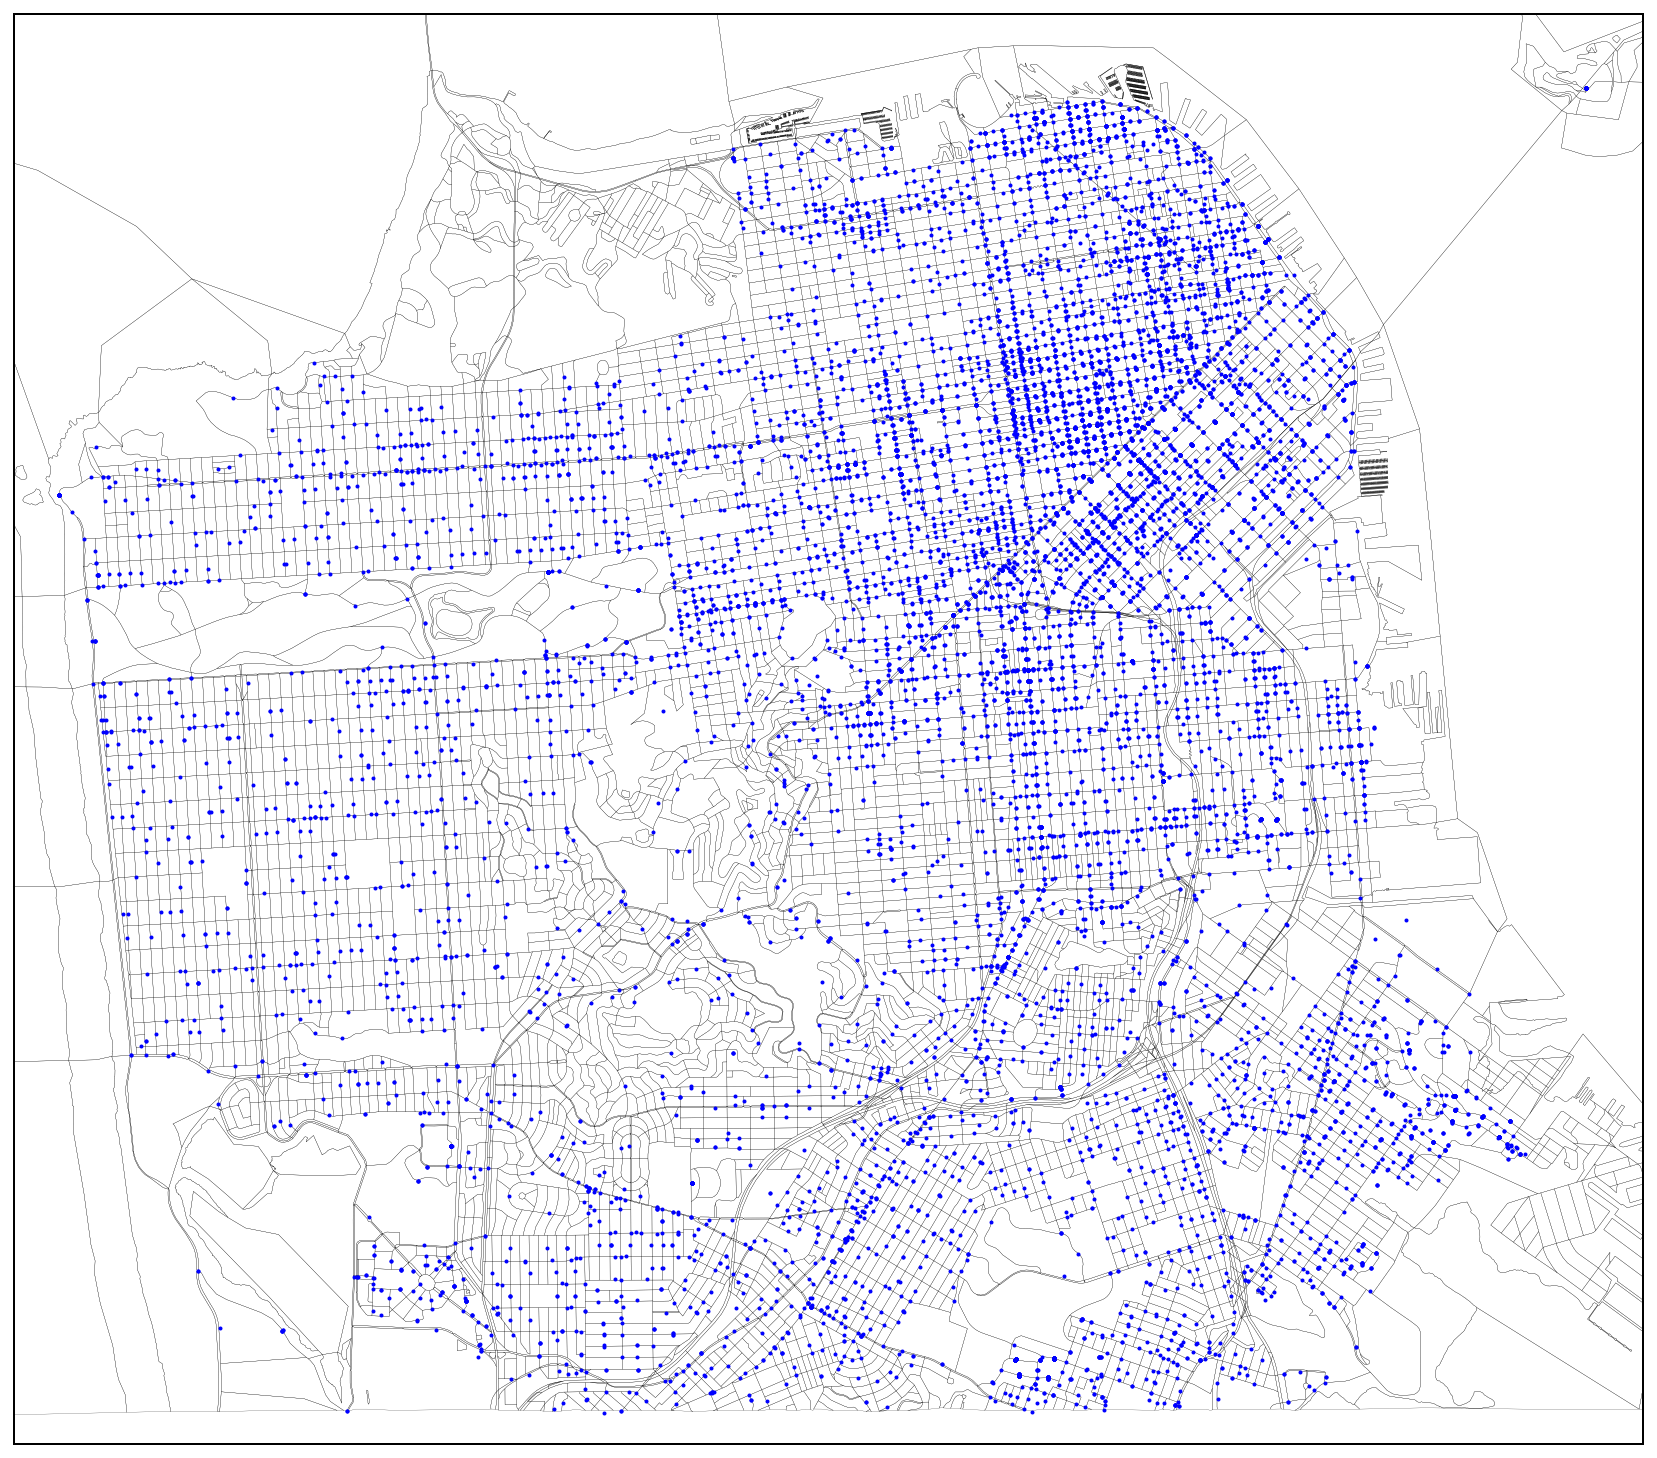

In [162]:
# y = crime_15up.Y.values[:50000]
# x = crime_15up.X.values[:50000]

y = crime_15up[crime_15up.Category == 'VANDALISM'].Y.values
x = crime_15up[crime_15up.Category == 'VANDALISM'].X.values

plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f','sf_blocks', linewidth=.1)

m.drawmapboundary(fill_color='white')

m.plot(x, y, 'bo', markersize=2, latlon=True)
#plt.title('contour lines over filled continent background')
plt.show()

Make some broader categories for the crime data. They might not end of being used, but it could be interesting to test the whether grouping into larger categories affects the model at all. The problem with grouping is that the categories exist for reasons - it is hard to condense them without masking possible signals.

In [163]:
cats_crime = ['WARRANTS', 'MISSING PERSON', 'ROBBERY', 'OTHER OFFENSES',
              'ASSAULT', 'SUICIDE', 'NON-CRIMINAL', 'LARCENY/THEFT',
              'WEAPON LAWS', 'VEHICLE THEFT', 'VANDALISM', 'BURGLARY',
              'DRUG/NARCOTIC', 'DRUNKENNESS', 'LIQUOR LAWS', 'SUSPICIOUS OCC',
              'RECOVERED VEHICLE', 'FRAUD', 'STOLEN PROPERTY',
              'DISORDERLY CONDUCT', 'SECONDARY CODES', 'TRESPASS', 'ARSON',
              'SEX OFFENSES, FORCIBLE', 'FORGERY/COUNTERFEITING', 'EMBEZZLEMENT',
              'RUNAWAY', 'PROSTITUTION', 'KIDNAPPING', 'GAMBLING',
              'DRIVING UNDER THE INFLUENCE', 'LOITERING', 'BRIBERY', 'EXTORTION',
              'FAMILY OFFENSES', 'BAD CHECKS', 'SEX OFFENSES, NON FORCIBLE',
              'PORNOGRAPHY/OBSCENE MAT', 'TREA']

big_cats_crime = {'theft_arson': ['ROBBERY', 'LARCENY/THEFT', 'VEHICLE THEFT', 
                                  'BURGLARY', 'STOLEN PROPERTY', 'ARSON'], 
                  'non_criminal': ['NON-CRIMINAL', 'MISSING PERSON', 'SUSPICIOUS OCC', 
                                   'RECOVERED VEHICLE', 'RUNAWAY'], 
                  'violent_crime': ['ASSAULT', 'WEAPON LAWS', 'SEX OFFENSES, FORCIBLE', 
                                    'KIDNAPPING', 'DRIVING UNDER THE INFLUENCE', 
                                    'FAMILY OFFENSES', 'SEX OFFENSES, NON FORCIBLE'],
                  'drugs_suicide': ['SUICIDE', 'DRUG/NARCOTIC', 'PROSTITUTION', 
                                    'PORNOGRAPHY/OBSCENE MAT'],
                  'vandalism_liquor': ['VANDALISM', 'DRUNKENNESS', 'LIQUOR LAWS', 
                                       'DISORDERLY CONDUCT', 'TRESPASS', 'LOITERING', 
                                       'TREA'], 
                  'other': ['WARRANTS', 'OTHER OFFENSES', 'SECONDARY CODES'], 
                  'money_related': ['FRAUD', 'FORGERY/COUNTERFEITING', 'EMBEZZLEMENT', 
                                    'GAMBLING', 'BRIBERY', 'EXTORTION', 'BAD CHECKS']}


## Park maps

The hypothesis is that rentals closer to parks are more desireable, therefore can be priced higher. This can possibly be accounted for by calculating distance to the nearest park.

Below I plot a shapefile of all San Francisco parks. In the map_data directory there is also a csv file with lat/long boundary points for every park.

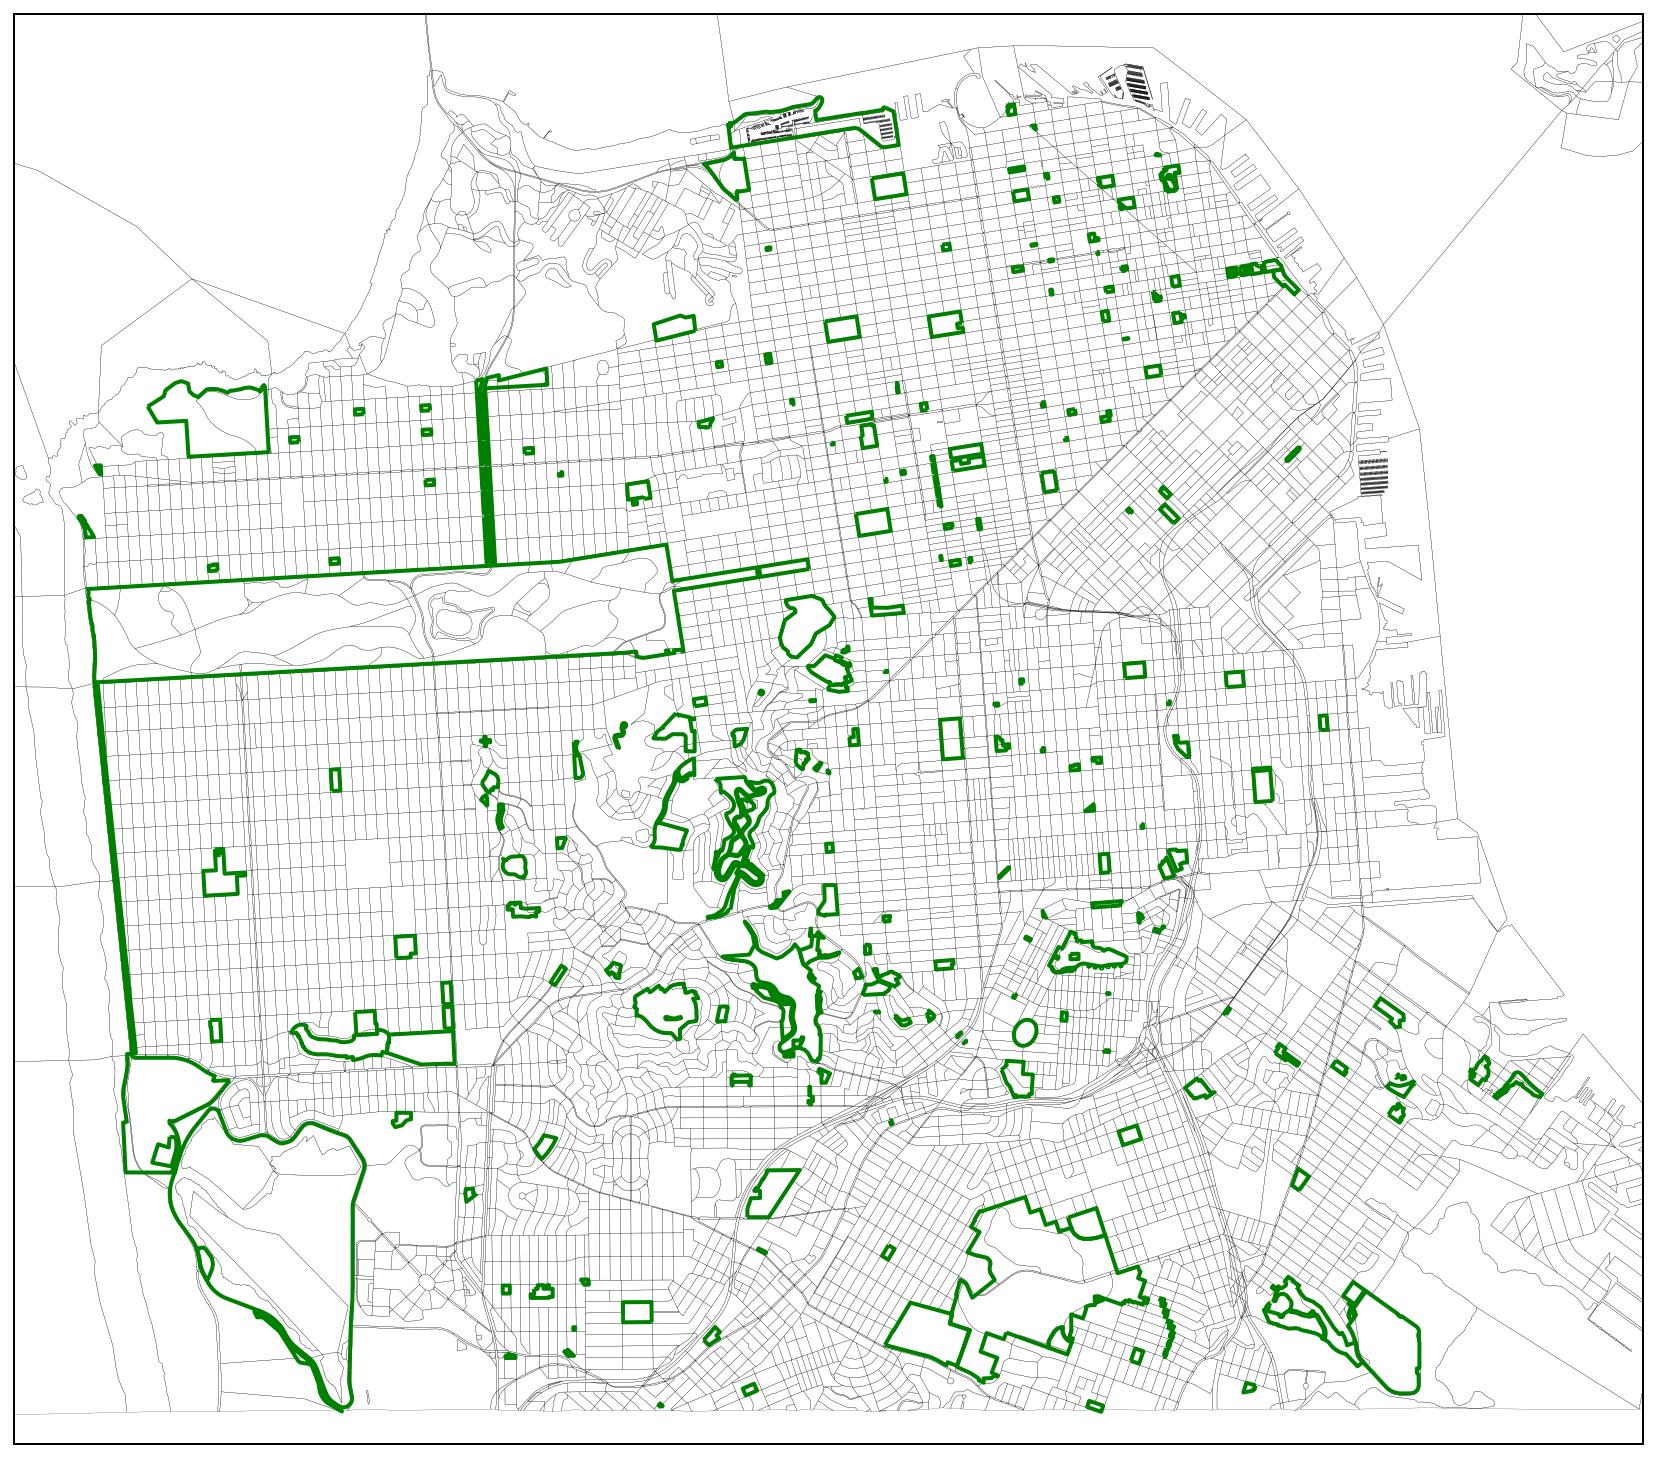

In [164]:
plt.figure(figsize=(13,13))
m = Basemap(llcrnrlon=-122.518,llcrnrlat=37.705683,urcrnrlon=-122.36,
            urcrnrlat=37.81534, resolution='h',projection='merc')

m.readshapefile('./map_data/census_blocks/geo_export_7c410ec8-5cfa-4422-9893-1d3d5cf3be1f',
                'sf_blocks', linewidth=.1)
m.readshapefile('./map_data/park_lands/geo_export_9cdf9323-886f-408a-bb55-833bfe6e102d',
                'sf_blocks', linewidth=2, color='g')

m.drawmapboundary(fill_color='white')

#m.plot(x, y, 'bo', markersize=2, latlon=True)
#plt.title('contour lines over filled continent background')
plt.show()

The csv below contains polygon boundary points for each of the parks (column name 'the_geom'). This is the column that will be used to see if a listing or property is close to a park - this might be considered a good attribute that would increase the value of a property. 

In [165]:
park_pnts = pd.read_csv('./map_data/RPD_Parks.csv')
print park_pnts.shape
park_pnts.head()

(222, 8)


map_park_n  \
0               Maritime Plaza   
1  Victoria Manalo Draves Park   
2    Crocker Amazon Playground   
3    Dearborn Community Garden   
4   Angelo J. Rossi Playground   

                                            the_geom    perimeter  gis_fd_pk  \
0  MULTIPOLYGON (((-122.39937368195233 37.7952515...  3208.814853        142   
1  MULTIPOLYGON (((-122.40553159596921 37.7762806...  1498.021103        169   
2  MULTIPOLYGON (((-122.43354460197526 37.7132539...  6738.886428        164   
3  MULTIPOLYGON (((-122.42291623023473 37.7622797...   338.000133     137654   
4  MULTIPOLYGON (((-122.45689530127527 37.7781510...  2609.521321        105   

            x          y          sqft      acres  
0 -122.399239  37.795605  8.767592e+04   2.012762  
1 -122.405955  37.777009  1.095939e+05   2.515930  
2 -122.429239  37.714046  2.459411e+06  56.460314  
3 -122.422744  37.762378  6.720006e+03   0.154270  
4 -122.457454  37.778742  2.818845e+05   6.471178

In [166]:
print park_scores.shape
park_scores.head()

(5495, 5)


ParkID   PSA                       Park      FQ  Score
0      86  PSA4           Carl Larsen Park  FY05Q3  0.795
1      13  PSA4  Junipero Serra Playground  FY05Q3  0.957
2       9  PSA4     Rolph Nicol Playground  FY05Q3  0.864
3     117  PSA2               Alamo Square  FY05Q4  0.857
4      60  PSA6   Jose Coronado Playground  FY05Q4  0.859

In [167]:
# not as many parks as in park data table above (one with multipolygon)
park_scores.ParkID.unique().shape

(184,)

The feature named 'the_geom' contains "MULTIPOLYGON" Lat/Long coordinates that trace the boundary of a given park.

I loaded the park shapefile into QGIS and created a new layer that consists of regularly spaced points along all park boundaries. Those points will become the array of Lat/Long points used to count for proximity.

### Combine 311 data as counts of different Categories within the query radius

In [168]:
bnb_list_full.reset_index(inplace=True, drop=True)
bnb_list_full.head()

id  host_total_listings_count   latitude   longitude  accommodates  \
0  11187767                        1.0  37.779685 -122.510472             6   
1   6938818                        2.0  37.780659 -122.505635             4   
2   9395222                        2.0  37.781433 -122.505179             4   
3   8388658                        1.0  37.787664 -122.489152             6   
4   7856443                        2.0  37.782133 -122.492730             6   

   bathrooms  bedrooms  beds  \
0        2.0       3.0   3.0   
1        1.0       1.0   2.0   
2        1.0       1.0   2.0   
3        2.5       3.0   4.0   
4        2.5       3.0   4.0   

                                           amenities  price      ...       \
0  {TV,"Cable TV","Wireless Internet",Kitchen,Hea...  400.0      ...        
1  {TV,Internet,"Wireless Internet",Kitchen,Heati...   99.0      ...        
2  {TV,Kitchen,"Free Parking on Premises","Pets A...  155.0      ...        
3  {TV,Internet,"Wireless Internet",Kitchen,"Free...  895.0      ...        
4  {TV,Internet,"Wireless Internet",Kitchen,"Free...  195.0      ...        

   Russian Hill  Seacliff  South of Market  Treasure Island/YBI  Twin Peaks  \
0             0         1                0                    0           0   
1             0         1                0                    0           0   
2             0         1                0                    0           0   
3             0         1                0                    0           0   
4             0         1                0                    0           0   

   Visitacion Valley  West of Twin Peaks  Western Addition  \
0                  0                   0                 0   
1                  0                   0                 0   
2                  0                   0                 0   
3                  0                   0                 0   
4                  0                   0                 0   

                                       geometry  census_tract  
0  POINT (-122.5104716962268 37.77968470054454)        479.01  
1  POINT (-122.5056347793022 37.78065902049909)        479.02  
2  POINT (-122.5051793274895 37.78143337110802)          9802  
3   POINT (-122.489152227618 37.78766423088835)           428  
4  POINT (-122.4927302695125 37.78213277410354)           427  

[5 rows x 91 columns]

Initially, I was going to combine the incidents for different crime and 311 request categories. In the end, I decided to just use individual categories so that there were no mixed signals.

In [170]:
# Not going to use the big categories

# rec_graff = rec_15up[(rec_15up.Category == 'Graffiti Public Property') | 
#                      (rec_15up.Category == 'Graffiti Private Property')]
# rec_graff_pts = rec_graff[['longitude', 'latitude']].as_matrix()

# rec_noise_con = rec_15up[(rec_15up.Category == 'Temporary Sign Request') | 
#                             (rec_15up.Category == 'Noise Report') | 
#                             (rec_15up.Category == 'Construction Zone Permits')]
# rec_noise_pts = rec_noise_con[['longitude', 'latitude']].as_matrix()

# rec_cosmetic = rec_15up[(rec_15up.Category == 'Color Curb') | 
#                         (rec_15up.Category == 'Illegal Postings') | 
#                         (rec_15up.Category == 'Rec and Park Requests') | 
#                         (rec_15up.Category == 'Litter Receptacles') | 
#                         (rec_15up.Category == 'Tree Maintenance')]
# rec_cosmetic_pts = rec_cosmetic[['longitude', 'latitude']].as_matrix()

# rec_damage = rec_15up[rec_15up.Category == 'Damaged Property']
# rec_damage_pts = rec_damage[['longitude', 'latitude']].as_matrix()

# rec_repair = rec_15up[(rec_15up.Category == 'Streetlights') | 
#                         (rec_15up.Category == 'Sewer Issues') | 
#                         (rec_15up.Category == 'Sign Repair') | 
#                         (rec_15up.Category == 'Sidewalk or Curb')]
# rec_repair_pts = rec_repair[['longitude', 'latitude']].as_matrix()

# rec_street = rec_15up[(rec_15up.Category == 'Street and Sidewalk Cleaning') | 
#                             (rec_15up.Category == 'Street Defects') | 
#                             (rec_15up.Category == 'Catch Basin Maintenance')]
# rec_street_pts = rec_street[['longitude', 'latitude']].as_matrix()